In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o, mammo_f, label = [], [], []
data_folder = "../dataset/"
os.chdir(data_folder)
l = os.listdir()

In [4]:
def create_dataset(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [5]:
os.chdir("./")
threads = []
chunk = 6

for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [6]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [7]:
def cnn_o(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(4, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [8]:
model_o = cnn_o()
model_o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 4)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 8)         2

In [9]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

Epoch 1/260
6/6 [==============================] - 2s 218ms/step - loss: 1.0453 - accuracy: 0.4957 - val_loss: 0.6899 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 151ms/step - loss: 0.6874 - accuracy: 0.6838 - val_loss: 0.6843 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 177ms/step - loss: 0.6214 - accuracy: 0.7094 - val_loss: 0.6795 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 155ms/step - loss: 0.6216 - accuracy: 0.6838 - val_loss: 0.6776 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 214ms/step - loss: 0.5787 - accuracy: 0.7179 - val_loss: 0.6756 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 174ms/step - loss: 0.5838 - accuracy: 0.7179 - val_loss: 0.6747 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 1s 136ms/step - loss: 0.5

6/6 [==============================] - 1s 99ms/step - loss: 0.4115 - accuracy: 0.7949 - val_loss: 0.6882 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 54/260
6/6 [==============================] - 1s 94ms/step - loss: 0.3866 - accuracy: 0.8291 - val_loss: 0.6878 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 55/260
6/6 [==============================] - 1s 108ms/step - loss: 0.4056 - accuracy: 0.8291 - val_loss: 0.6875 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 56/260
6/6 [==============================] - 1s 95ms/step - loss: 0.4149 - accuracy: 0.7949 - val_loss: 0.6872 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 57/260
6/6 [==============================] - 1s 90ms/step - loss: 0.4164 - accuracy: 0.8120 - val_loss: 0.6869 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 58/260
6/6 [==============================] - 1s 95ms/step - loss: 0.4286 - accuracy: 0.8120 - val_loss: 0.6864 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 59/260
6/6 [==============================] - 1s 95ms/step

Epoch 105/260
6/6 [==============================] - 1s 94ms/step - loss: 0.3999 - accuracy: 0.8034 - val_loss: 0.6658 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 106/260
6/6 [==============================] - 1s 99ms/step - loss: 0.3911 - accuracy: 0.8291 - val_loss: 0.6652 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 107/260
6/6 [==============================] - 1s 93ms/step - loss: 0.3998 - accuracy: 0.8462 - val_loss: 0.6646 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 108/260
6/6 [==============================] - 1s 101ms/step - loss: 0.4145 - accuracy: 0.7949 - val_loss: 0.6641 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 109/260
6/6 [==============================] - 1s 124ms/step - loss: 0.3914 - accuracy: 0.8462 - val_loss: 0.6635 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 110/260
6/6 [==============================] - 1s 89ms/step - loss: 0.3840 - accuracy: 0.8120 - val_loss: 0.6632 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 111/260
6/6 [=========================

6/6 [==============================] - 1s 155ms/step - loss: 0.4089 - accuracy: 0.8120 - val_loss: 0.6259 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 157/260
6/6 [==============================] - 1s 129ms/step - loss: 0.4087 - accuracy: 0.8205 - val_loss: 0.6256 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 158/260
6/6 [==============================] - 1s 101ms/step - loss: 0.3923 - accuracy: 0.8291 - val_loss: 0.6254 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 159/260
6/6 [==============================] - 1s 102ms/step - loss: 0.4194 - accuracy: 0.8120 - val_loss: 0.6249 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 160/260
6/6 [==============================] - 1s 138ms/step - loss: 0.3672 - accuracy: 0.8376 - val_loss: 0.6248 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 161/260
6/6 [==============================] - 1s 94ms/step - loss: 0.4056 - accuracy: 0.8034 - val_loss: 0.6245 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 162/260
6/6 [==============================] - 1s

6/6 [==============================] - 1s 99ms/step - loss: 0.4122 - accuracy: 0.8205 - val_loss: 0.6215 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 208/260
6/6 [==============================] - 1s 128ms/step - loss: 0.3807 - accuracy: 0.8547 - val_loss: 0.6213 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 209/260
6/6 [==============================] - 1s 96ms/step - loss: 0.4057 - accuracy: 0.8120 - val_loss: 0.6212 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 210/260
6/6 [==============================] - 1s 95ms/step - loss: 0.4201 - accuracy: 0.8034 - val_loss: 0.6214 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 211/260
6/6 [==============================] - 1s 123ms/step - loss: 0.4130 - accuracy: 0.8376 - val_loss: 0.6213 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 212/260
6/6 [==============================] - 1s 133ms/step - loss: 0.3917 - accuracy: 0.8291 - val_loss: 0.6213 - val_accuracy: 0.6000 - lr: 1.0000e-12
Epoch 213/260
6/6 [==============================] - 1s 1

6/6 [==============================] - 1s 93ms/step - loss: 0.4162 - accuracy: 0.8205 - val_loss: 0.6208 - val_accuracy: 0.6000 - lr: 1.0000e-15
Epoch 259/260
6/6 [==============================] - 1s 87ms/step - loss: 0.4118 - accuracy: 0.8205 - val_loss: 0.6207 - val_accuracy: 0.6000 - lr: 1.0000e-15
Epoch 260/260
6/6 [==============================] - 1s 98ms/step - loss: 0.4136 - accuracy: 0.8120 - val_loss: 0.6208 - val_accuracy: 0.6000 - lr: 1.0000e-15


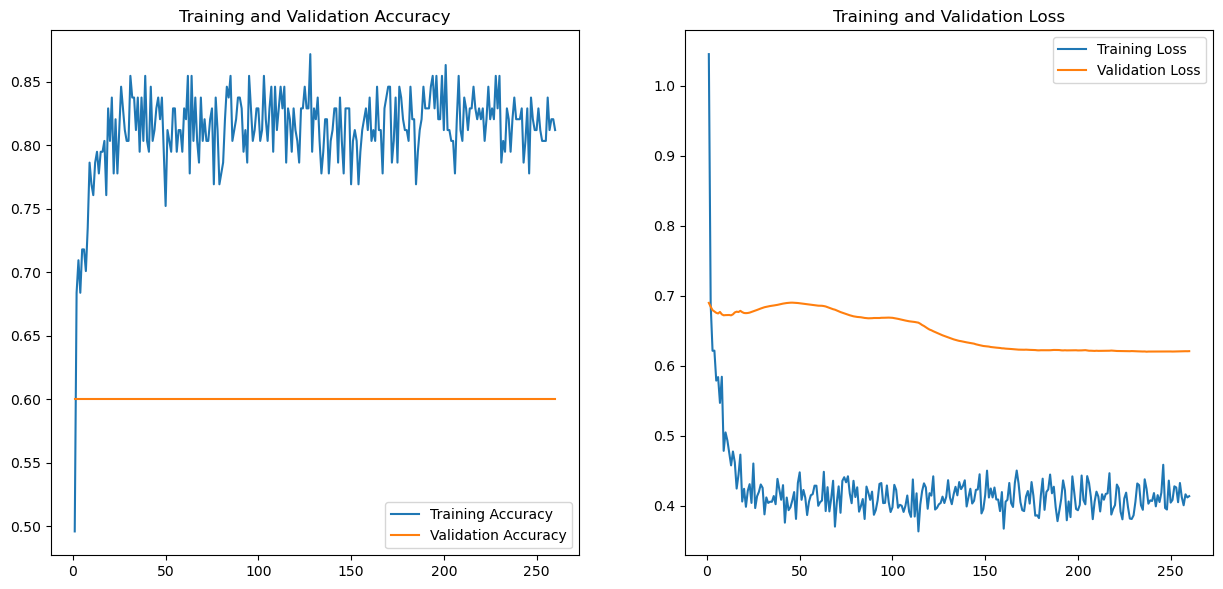

Validation accuracy: 0.600
Epoch 1/260
6/6 [==============================] - 2s 178ms/step - loss: 1.3205 - accuracy: 0.3761 - val_loss: 0.6906 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 138ms/step - loss: 0.7530 - accuracy: 0.6496 - val_loss: 0.6858 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 130ms/step - loss: 0.6446 - accuracy: 0.6410 - val_loss: 0.6872 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 127ms/step - loss: 0.6260 - accuracy: 0.6410 - val_loss: 0.6858 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 127ms/step - loss: 0.6227 - accuracy: 0.6410 - val_loss: 0.6836 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 132ms/step - loss: 0.5795 - accuracy: 0.6410 - val_loss: 0.6803 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] 

Epoch 54/260
6/6 [==============================] - 1s 133ms/step - loss: 0.4688 - accuracy: 0.6752 - val_loss: 0.6588 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 55/260
6/6 [==============================] - 1s 143ms/step - loss: 0.4591 - accuracy: 0.7607 - val_loss: 0.6494 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 56/260
6/6 [==============================] - 1s 99ms/step - loss: 0.4624 - accuracy: 0.7692 - val_loss: 0.6457 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 57/260
6/6 [==============================] - 1s 105ms/step - loss: 0.4565 - accuracy: 0.7949 - val_loss: 0.6442 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 58/260
6/6 [==============================] - 1s 128ms/step - loss: 0.4548 - accuracy: 0.7607 - val_loss: 0.6432 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 59/260
6/6 [==============================] - 1s 100ms/step - loss: 0.4487 - accuracy: 0.7863 - val_loss: 0.6429 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 60/260
6/6 [==============================] -

Epoch 106/260
6/6 [==============================] - 1s 116ms/step - loss: 0.4404 - accuracy: 0.7607 - val_loss: 0.6090 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 107/260
6/6 [==============================] - 1s 88ms/step - loss: 0.4263 - accuracy: 0.7863 - val_loss: 0.6112 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 108/260
6/6 [==============================] - 1s 94ms/step - loss: 0.4303 - accuracy: 0.8205 - val_loss: 0.6106 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 109/260
6/6 [==============================] - 1s 89ms/step - loss: 0.4256 - accuracy: 0.7778 - val_loss: 0.6096 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 110/260
6/6 [==============================] - 1s 86ms/step - loss: 0.4324 - accuracy: 0.7692 - val_loss: 0.6097 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 111/260
6/6 [==============================] - 1s 87ms/step - loss: 0.4425 - accuracy: 0.8120 - val_loss: 0.6087 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 112/260
6/6 [==========================

6/6 [==============================] - 1s 86ms/step - loss: 0.4274 - accuracy: 0.8034 - val_loss: 0.5988 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 158/260
6/6 [==============================] - 1s 94ms/step - loss: 0.4133 - accuracy: 0.7863 - val_loss: 0.5988 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 159/260
6/6 [==============================] - 1s 88ms/step - loss: 0.4502 - accuracy: 0.7521 - val_loss: 0.5989 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 160/260
6/6 [==============================] - 1s 104ms/step - loss: 0.4218 - accuracy: 0.8205 - val_loss: 0.5990 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 161/260
6/6 [==============================] - 1s 107ms/step - loss: 0.4364 - accuracy: 0.7692 - val_loss: 0.5990 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 162/260
6/6 [==============================] - 1s 105ms/step - loss: 0.4316 - accuracy: 0.8120 - val_loss: 0.5991 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 163/260
6/6 [==============================] - 1s 8

6/6 [==============================] - 1s 94ms/step - loss: 0.4351 - accuracy: 0.7949 - val_loss: 0.5995 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 209/260
6/6 [==============================] - 1s 105ms/step - loss: 0.4516 - accuracy: 0.7692 - val_loss: 0.5994 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 210/260
6/6 [==============================] - 1s 99ms/step - loss: 0.4483 - accuracy: 0.7692 - val_loss: 0.5993 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 211/260
6/6 [==============================] - 1s 121ms/step - loss: 0.4544 - accuracy: 0.8034 - val_loss: 0.5994 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 212/260
6/6 [==============================] - 1s 100ms/step - loss: 0.4418 - accuracy: 0.7521 - val_loss: 0.5993 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 213/260
6/6 [==============================] - 1s 95ms/step - loss: 0.4231 - accuracy: 0.8291 - val_loss: 0.5994 - val_accuracy: 0.7000 - lr: 1.0000e-13
Epoch 214/260
6/6 [==============================] - 1s 1

6/6 [==============================] - 1s 126ms/step - loss: 0.4603 - accuracy: 0.7692 - val_loss: 0.5994 - val_accuracy: 0.7000 - lr: 1.0000e-17
Epoch 260/260
6/6 [==============================] - 1s 135ms/step - loss: 0.4196 - accuracy: 0.8120 - val_loss: 0.5994 - val_accuracy: 0.7000 - lr: 1.0000e-17


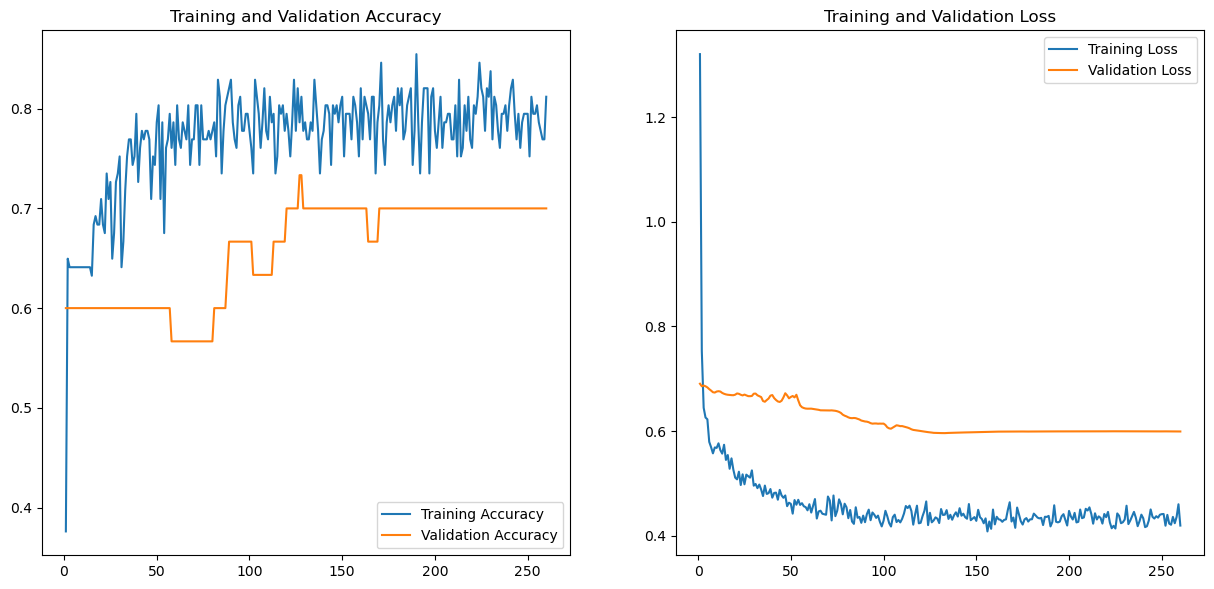

Validation accuracy: 0.700
Epoch 1/260
6/6 [==============================] - 2s 154ms/step - loss: 0.7670 - accuracy: 0.6667 - val_loss: 0.6929 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 111ms/step - loss: 0.7182 - accuracy: 0.6410 - val_loss: 0.6879 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 125ms/step - loss: 0.6643 - accuracy: 0.6838 - val_loss: 0.6848 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 117ms/step - loss: 0.6173 - accuracy: 0.6838 - val_loss: 0.6840 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 125ms/step - loss: 0.5453 - accuracy: 0.7350 - val_loss: 0.6778 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 153ms/step - loss: 0.5251 - accuracy: 0.7350 - val_loss: 0.6766 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] 

Epoch 54/260
6/6 [==============================] - 1s 86ms/step - loss: 0.3190 - accuracy: 0.8547 - val_loss: 0.6146 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 55/260
6/6 [==============================] - 1s 88ms/step - loss: 0.3147 - accuracy: 0.8376 - val_loss: 0.5978 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 56/260
6/6 [==============================] - 1s 99ms/step - loss: 0.3061 - accuracy: 0.8462 - val_loss: 0.5783 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 57/260
6/6 [==============================] - 1s 96ms/step - loss: 0.2742 - accuracy: 0.8803 - val_loss: 0.5878 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 58/260
6/6 [==============================] - 1s 95ms/step - loss: 0.3677 - accuracy: 0.8120 - val_loss: 0.5882 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 59/260
6/6 [==============================] - 1s 97ms/step - loss: 0.2528 - accuracy: 0.9060 - val_loss: 0.5701 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 60/260
6/6 [==============================] - 1s 86ms/step - loss: 0.2

Epoch 107/260
6/6 [==============================] - 1s 93ms/step - loss: 0.1586 - accuracy: 0.9487 - val_loss: 0.5019 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 108/260
6/6 [==============================] - 1s 105ms/step - loss: 0.1881 - accuracy: 0.9231 - val_loss: 0.5020 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 109/260
6/6 [==============================] - 1s 94ms/step - loss: 0.1615 - accuracy: 0.9231 - val_loss: 0.5014 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 110/260
6/6 [==============================] - 1s 86ms/step - loss: 0.1814 - accuracy: 0.8889 - val_loss: 0.5009 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 111/260
6/6 [==============================] - 1s 86ms/step - loss: 0.1490 - accuracy: 0.9487 - val_loss: 0.5002 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 112/260
6/6 [==============================] - 1s 138ms/step - loss: 0.1716 - accuracy: 0.9316 - val_loss: 0.4993 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 113/260
6/6 [=========================

6/6 [==============================] - 1s 125ms/step - loss: 0.1725 - accuracy: 0.9573 - val_loss: 0.4971 - val_accuracy: 0.7333 - lr: 1.0000e-10
Epoch 159/260
6/6 [==============================] - 1s 100ms/step - loss: 0.1644 - accuracy: 0.9402 - val_loss: 0.4970 - val_accuracy: 0.7333 - lr: 1.0000e-10
Epoch 160/260
6/6 [==============================] - 1s 92ms/step - loss: 0.1678 - accuracy: 0.9316 - val_loss: 0.4971 - val_accuracy: 0.7333 - lr: 1.0000e-10
Epoch 161/260
6/6 [==============================] - 1s 150ms/step - loss: 0.1681 - accuracy: 0.9231 - val_loss: 0.4969 - val_accuracy: 0.7333 - lr: 1.0000e-10
Epoch 162/260
6/6 [==============================] - 1s 98ms/step - loss: 0.1853 - accuracy: 0.9145 - val_loss: 0.4968 - val_accuracy: 0.7333 - lr: 1.0000e-10
Epoch 163/260
6/6 [==============================] - 1s 89ms/step - loss: 0.1688 - accuracy: 0.9402 - val_loss: 0.4968 - val_accuracy: 0.7333 - lr: 1.0000e-10
Epoch 164/260
6/6 [==============================] - 1s 8

6/6 [==============================] - 1s 148ms/step - loss: 0.1927 - accuracy: 0.9402 - val_loss: 0.4969 - val_accuracy: 0.7333 - lr: 1.0000e-15
Epoch 210/260
6/6 [==============================] - 1s 134ms/step - loss: 0.1553 - accuracy: 0.9316 - val_loss: 0.4968 - val_accuracy: 0.7333 - lr: 1.0000e-15
Epoch 211/260
6/6 [==============================] - 1s 121ms/step - loss: 0.1677 - accuracy: 0.9402 - val_loss: 0.4968 - val_accuracy: 0.7333 - lr: 1.0000e-15
Epoch 212/260
6/6 [==============================] - 1s 95ms/step - loss: 0.1989 - accuracy: 0.9145 - val_loss: 0.4971 - val_accuracy: 0.7333 - lr: 1.0000e-15
Epoch 213/260
6/6 [==============================] - 1s 93ms/step - loss: 0.1618 - accuracy: 0.9487 - val_loss: 0.4971 - val_accuracy: 0.7333 - lr: 1.0000e-15
Epoch 214/260
6/6 [==============================] - 1s 93ms/step - loss: 0.1973 - accuracy: 0.9060 - val_loss: 0.4970 - val_accuracy: 0.7333 - lr: 1.0000e-15
Epoch 215/260
6/6 [==============================] - 1s 1

6/6 [==============================] - 1s 101ms/step - loss: 0.1427 - accuracy: 0.9316 - val_loss: 0.4975 - val_accuracy: 0.7333 - lr: 1.0000e-20


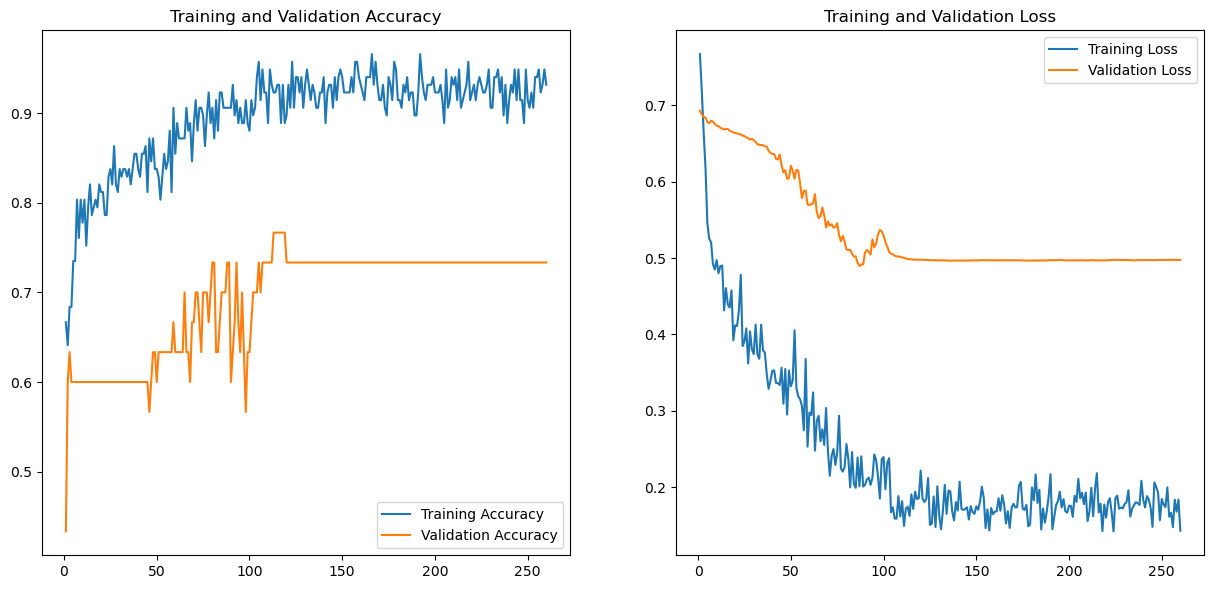

Validation accuracy: 0.733
Epoch 1/260
6/6 [==============================] - 2s 152ms/step - loss: 0.8887 - accuracy: 0.4957 - val_loss: 0.6936 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 93ms/step - loss: 0.6637 - accuracy: 0.5812 - val_loss: 0.6935 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 93ms/step - loss: 0.6353 - accuracy: 0.6496 - val_loss: 0.6930 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 103ms/step - loss: 0.6264 - accuracy: 0.6410 - val_loss: 0.6927 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 94ms/step - loss: 0.5697 - accuracy: 0.6410 - val_loss: 0.6926 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 88ms/step - loss: 0.5830 - accuracy: 0.6496 - val_loss: 0.6926 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 1s

Epoch 54/260
6/6 [==============================] - 1s 96ms/step - loss: 0.3748 - accuracy: 0.8462 - val_loss: 0.6280 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 55/260
6/6 [==============================] - 1s 95ms/step - loss: 0.3819 - accuracy: 0.8120 - val_loss: 0.6255 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 56/260
6/6 [==============================] - 1s 128ms/step - loss: 0.3959 - accuracy: 0.8291 - val_loss: 0.6225 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 57/260
6/6 [==============================] - 1s 97ms/step - loss: 0.3508 - accuracy: 0.8376 - val_loss: 0.6194 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 58/260
6/6 [==============================] - 1s 112ms/step - loss: 0.3760 - accuracy: 0.8376 - val_loss: 0.6132 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 59/260
6/6 [==============================] - 1s 127ms/step - loss: 0.3699 - accuracy: 0.8205 - val_loss: 0.6081 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 60/260
6/6 [==============================] - 1s 87ms/step - loss: 

6/6 [==============================] - 1s 125ms/step - loss: 0.2995 - accuracy: 0.8632 - val_loss: 0.6052 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 107/260
6/6 [==============================] - 1s 131ms/step - loss: 0.2954 - accuracy: 0.8889 - val_loss: 0.6053 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 108/260
6/6 [==============================] - 1s 133ms/step - loss: 0.2844 - accuracy: 0.8974 - val_loss: 0.6054 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 109/260
6/6 [==============================] - 1s 124ms/step - loss: 0.2752 - accuracy: 0.8974 - val_loss: 0.6056 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 110/260
6/6 [==============================] - 1s 133ms/step - loss: 0.2824 - accuracy: 0.8889 - val_loss: 0.6058 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 111/260
6/6 [==============================] - 1s 135ms/step - loss: 0.3010 - accuracy: 0.8803 - val_loss: 0.6060 - val_accuracy: 0.6667 - lr: 1.0000e-07
Epoch 112/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 127ms/step - loss: 0.3261 - accuracy: 0.8462 - val_loss: 0.6126 - val_accuracy: 0.6667 - lr: 1.0000e-11
Epoch 158/260
6/6 [==============================] - 1s 130ms/step - loss: 0.2866 - accuracy: 0.8803 - val_loss: 0.6127 - val_accuracy: 0.6667 - lr: 1.0000e-11
Epoch 159/260
6/6 [==============================] - 1s 133ms/step - loss: 0.2996 - accuracy: 0.8376 - val_loss: 0.6128 - val_accuracy: 0.6667 - lr: 1.0000e-11
Epoch 160/260
6/6 [==============================] - 1s 128ms/step - loss: 0.3328 - accuracy: 0.8632 - val_loss: 0.6128 - val_accuracy: 0.6667 - lr: 1.0000e-11
Epoch 161/260
6/6 [==============================] - 1s 101ms/step - loss: 0.3143 - accuracy: 0.8718 - val_loss: 0.6129 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 162/260
6/6 [==============================] - 1s 99ms/step - loss: 0.2995 - accuracy: 0.8547 - val_loss: 0.6130 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 163/260
6/6 [==============================] - 1s

6/6 [==============================] - 1s 130ms/step - loss: 0.3060 - accuracy: 0.8547 - val_loss: 0.6136 - val_accuracy: 0.6667 - lr: 1.0000e-16
Epoch 209/260
6/6 [==============================] - 1s 129ms/step - loss: 0.3344 - accuracy: 0.8291 - val_loss: 0.6137 - val_accuracy: 0.6667 - lr: 1.0000e-16
Epoch 210/260
6/6 [==============================] - 1s 99ms/step - loss: 0.3197 - accuracy: 0.8718 - val_loss: 0.6137 - val_accuracy: 0.6667 - lr: 1.0000e-16
Epoch 211/260
6/6 [==============================] - 1s 102ms/step - loss: 0.3175 - accuracy: 0.8462 - val_loss: 0.6136 - val_accuracy: 0.6667 - lr: 1.0000e-17
Epoch 212/260
6/6 [==============================] - 1s 129ms/step - loss: 0.3039 - accuracy: 0.8718 - val_loss: 0.6137 - val_accuracy: 0.6667 - lr: 1.0000e-17
Epoch 213/260
6/6 [==============================] - 1s 111ms/step - loss: 0.3037 - accuracy: 0.8889 - val_loss: 0.6138 - val_accuracy: 0.6667 - lr: 1.0000e-17
Epoch 214/260
6/6 [==============================] - 1s

6/6 [==============================] - 1s 137ms/step - loss: 0.3102 - accuracy: 0.8632 - val_loss: 0.6138 - val_accuracy: 0.6667 - lr: 1.0000e-21
Epoch 260/260
6/6 [==============================] - 1s 148ms/step - loss: 0.3165 - accuracy: 0.8547 - val_loss: 0.6138 - val_accuracy: 0.6667 - lr: 1.0000e-21


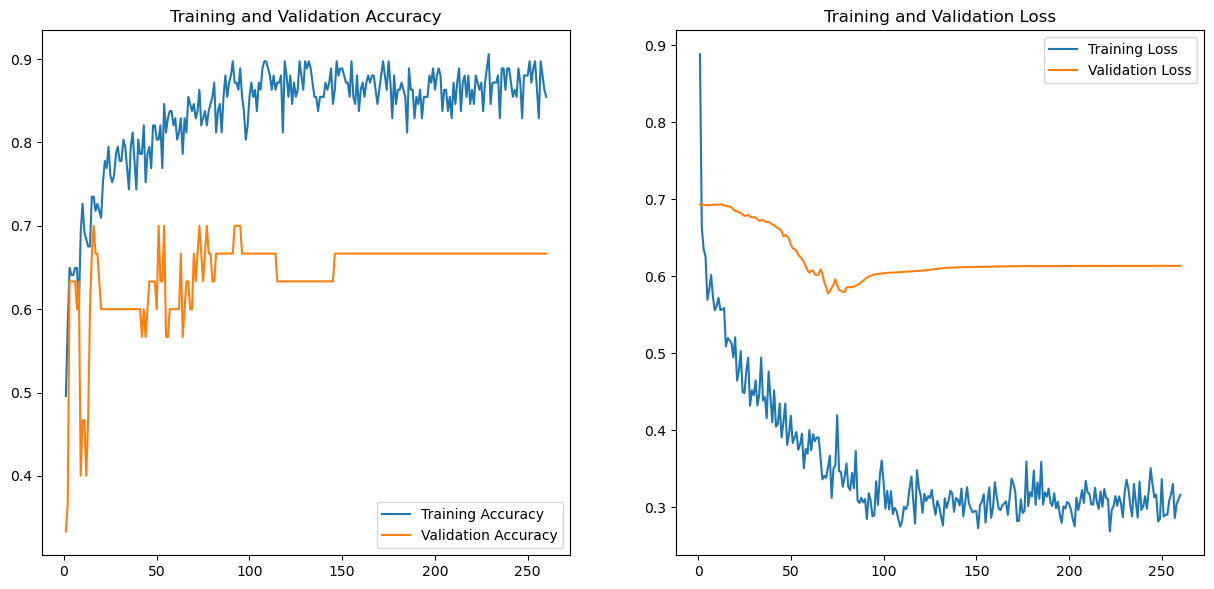

Validation accuracy: 0.667
Epoch 1/260
6/6 [==============================] - 2s 207ms/step - loss: 0.7835 - accuracy: 0.5641 - val_loss: 0.6875 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 130ms/step - loss: 0.6651 - accuracy: 0.6325 - val_loss: 0.6795 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 109ms/step - loss: 0.5988 - accuracy: 0.6239 - val_loss: 0.6680 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 92ms/step - loss: 0.5898 - accuracy: 0.7179 - val_loss: 0.6639 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 171ms/step - loss: 0.5579 - accuracy: 0.7094 - val_loss: 0.6622 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 136ms/step - loss: 0.5588 - accuracy: 0.7009 - val_loss: 0.6579 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] -

Epoch 53/260
6/6 [==============================] - 1s 164ms/step - loss: 0.4224 - accuracy: 0.8205 - val_loss: 0.5913 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 54/260
6/6 [==============================] - 1s 133ms/step - loss: 0.3881 - accuracy: 0.8376 - val_loss: 0.5910 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 55/260
6/6 [==============================] - 1s 152ms/step - loss: 0.4232 - accuracy: 0.8120 - val_loss: 0.5908 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 56/260
6/6 [==============================] - 1s 137ms/step - loss: 0.4098 - accuracy: 0.8205 - val_loss: 0.5908 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 57/260
6/6 [==============================] - 1s 147ms/step - loss: 0.4023 - accuracy: 0.8291 - val_loss: 0.5902 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 58/260
6/6 [==============================] - 1s 129ms/step - loss: 0.3646 - accuracy: 0.8291 - val_loss: 0.5895 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 59/260
6/6 [============================

6/6 [==============================] - 1s 135ms/step - loss: 0.4106 - accuracy: 0.8205 - val_loss: 0.5656 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 105/260
6/6 [==============================] - 1s 168ms/step - loss: 0.4310 - accuracy: 0.7949 - val_loss: 0.5653 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 106/260
6/6 [==============================] - 1s 129ms/step - loss: 0.3928 - accuracy: 0.8120 - val_loss: 0.5652 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 107/260
6/6 [==============================] - 1s 140ms/step - loss: 0.3901 - accuracy: 0.8205 - val_loss: 0.5651 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 108/260
6/6 [==============================] - 1s 149ms/step - loss: 0.3609 - accuracy: 0.8462 - val_loss: 0.5651 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 109/260
6/6 [==============================] - 1s 158ms/step - loss: 0.4390 - accuracy: 0.7778 - val_loss: 0.5650 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 110/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 98ms/step - loss: 0.3975 - accuracy: 0.8034 - val_loss: 0.5648 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 156/260
6/6 [==============================] - 1s 139ms/step - loss: 0.4046 - accuracy: 0.8547 - val_loss: 0.5648 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 157/260
6/6 [==============================] - 1s 133ms/step - loss: 0.3758 - accuracy: 0.8120 - val_loss: 0.5649 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 158/260
6/6 [==============================] - 1s 106ms/step - loss: 0.4065 - accuracy: 0.7949 - val_loss: 0.5649 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 159/260
6/6 [==============================] - 1s 144ms/step - loss: 0.3921 - accuracy: 0.8291 - val_loss: 0.5649 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 160/260
6/6 [==============================] - 1s 142ms/step - loss: 0.3877 - accuracy: 0.8205 - val_loss: 0.5649 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 161/260
6/6 [==============================] - 1s

6/6 [==============================] - 1s 155ms/step - loss: 0.3782 - accuracy: 0.8462 - val_loss: 0.5645 - val_accuracy: 0.7000 - lr: 1.0000e-16
Epoch 207/260
6/6 [==============================] - 1s 145ms/step - loss: 0.3606 - accuracy: 0.8376 - val_loss: 0.5646 - val_accuracy: 0.7000 - lr: 1.0000e-16
Epoch 208/260
6/6 [==============================] - 1s 154ms/step - loss: 0.3665 - accuracy: 0.8120 - val_loss: 0.5646 - val_accuracy: 0.7000 - lr: 1.0000e-16
Epoch 209/260
6/6 [==============================] - 1s 140ms/step - loss: 0.3923 - accuracy: 0.8462 - val_loss: 0.5646 - val_accuracy: 0.7000 - lr: 1.0000e-16
Epoch 210/260
6/6 [==============================] - 1s 144ms/step - loss: 0.3899 - accuracy: 0.8205 - val_loss: 0.5647 - val_accuracy: 0.7000 - lr: 1.0000e-16
Epoch 211/260
6/6 [==============================] - 1s 137ms/step - loss: 0.3825 - accuracy: 0.8547 - val_loss: 0.5647 - val_accuracy: 0.7000 - lr: 1.0000e-16
Epoch 212/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 148ms/step - loss: 0.3445 - accuracy: 0.8803 - val_loss: 0.5645 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 258/260
6/6 [==============================] - 1s 134ms/step - loss: 0.3736 - accuracy: 0.8462 - val_loss: 0.5645 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 259/260
6/6 [==============================] - 1s 142ms/step - loss: 0.3623 - accuracy: 0.8632 - val_loss: 0.5645 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 260/260
6/6 [==============================] - 1s 157ms/step - loss: 0.3801 - accuracy: 0.8462 - val_loss: 0.5646 - val_accuracy: 0.7000 - lr: 1.0000e-21


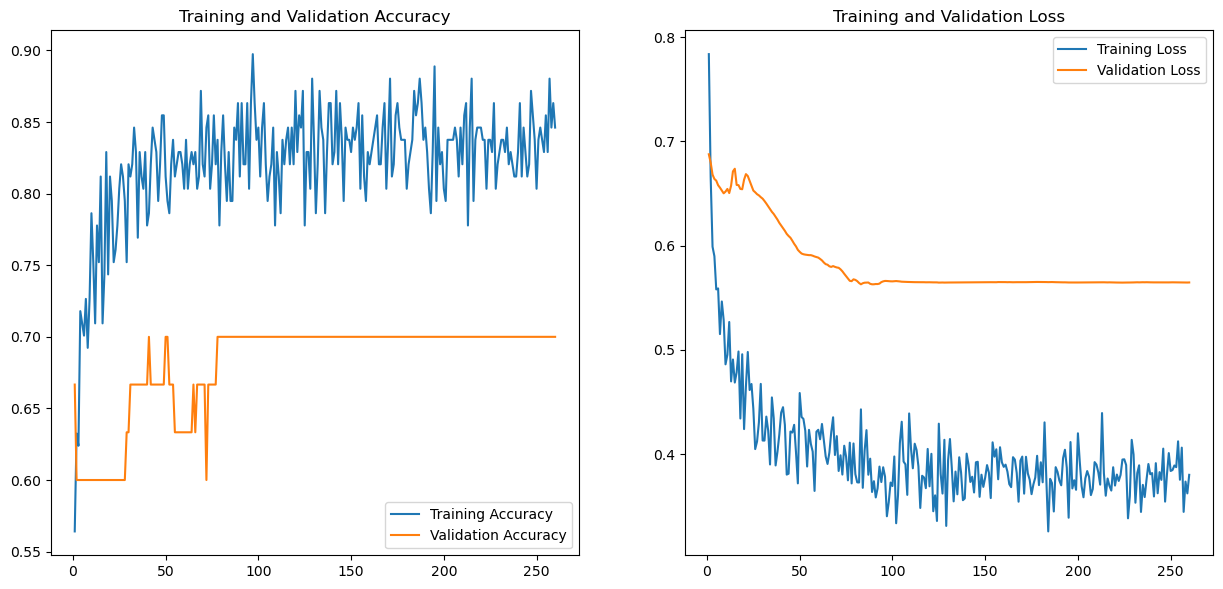

Validation accuracy: 0.700
Epoch 1/260
6/6 [==============================] - 3s 241ms/step - loss: 0.8333 - accuracy: 0.5470 - val_loss: 0.6966 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 137ms/step - loss: 0.7001 - accuracy: 0.6496 - val_loss: 0.6800 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 131ms/step - loss: 0.6010 - accuracy: 0.6838 - val_loss: 0.6675 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 156ms/step - loss: 0.5797 - accuracy: 0.7265 - val_loss: 0.6632 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 143ms/step - loss: 0.6165 - accuracy: 0.6667 - val_loss: 0.6646 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 155ms/step - loss: 0.5684 - accuracy: 0.7094 - val_loss: 0.6627 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/260
6/6 [==============================] 

Epoch 53/260
6/6 [==============================] - 1s 143ms/step - loss: 0.4947 - accuracy: 0.7692 - val_loss: 0.6417 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 54/260
6/6 [==============================] - 1s 135ms/step - loss: 0.5128 - accuracy: 0.7692 - val_loss: 0.6390 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 55/260
6/6 [==============================] - 1s 150ms/step - loss: 0.5140 - accuracy: 0.7265 - val_loss: 0.6366 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 56/260
6/6 [==============================] - 1s 142ms/step - loss: 0.5011 - accuracy: 0.7778 - val_loss: 0.6341 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 57/260
6/6 [==============================] - 1s 117ms/step - loss: 0.4539 - accuracy: 0.7778 - val_loss: 0.6318 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 58/260
6/6 [==============================] - 1s 124ms/step - loss: 0.4644 - accuracy: 0.7607 - val_loss: 0.6294 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 59/260
6/6 [============================

6/6 [==============================] - 1s 149ms/step - loss: 0.5104 - accuracy: 0.7265 - val_loss: 0.5799 - val_accuracy: 0.6333 - lr: 1.0000e-06
Epoch 105/260
6/6 [==============================] - 1s 144ms/step - loss: 0.4801 - accuracy: 0.7692 - val_loss: 0.5798 - val_accuracy: 0.6333 - lr: 1.0000e-06
Epoch 106/260
6/6 [==============================] - 1s 145ms/step - loss: 0.5118 - accuracy: 0.7436 - val_loss: 0.5795 - val_accuracy: 0.6333 - lr: 1.0000e-06
Epoch 107/260
6/6 [==============================] - 1s 171ms/step - loss: 0.4884 - accuracy: 0.7692 - val_loss: 0.5794 - val_accuracy: 0.6333 - lr: 1.0000e-06
Epoch 108/260
6/6 [==============================] - 1s 146ms/step - loss: 0.4939 - accuracy: 0.7436 - val_loss: 0.5793 - val_accuracy: 0.6333 - lr: 1.0000e-06
Epoch 109/260
6/6 [==============================] - 1s 144ms/step - loss: 0.4763 - accuracy: 0.7949 - val_loss: 0.5792 - val_accuracy: 0.6333 - lr: 1.0000e-06
Epoch 110/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 138ms/step - loss: 0.4966 - accuracy: 0.7521 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 156/260
6/6 [==============================] - 1s 150ms/step - loss: 0.4906 - accuracy: 0.7607 - val_loss: 0.5771 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 157/260
6/6 [==============================] - 1s 147ms/step - loss: 0.4798 - accuracy: 0.7863 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 158/260
6/6 [==============================] - 1s 136ms/step - loss: 0.4927 - accuracy: 0.7692 - val_loss: 0.5769 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 159/260
6/6 [==============================] - 1s 129ms/step - loss: 0.4949 - accuracy: 0.7607 - val_loss: 0.5769 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 160/260
6/6 [==============================] - 1s 146ms/step - loss: 0.4711 - accuracy: 0.7863 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 161/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 136ms/step - loss: 0.4976 - accuracy: 0.7692 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 207/260
6/6 [==============================] - 1s 137ms/step - loss: 0.4737 - accuracy: 0.7863 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 208/260
6/6 [==============================] - 1s 164ms/step - loss: 0.4946 - accuracy: 0.7607 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 209/260
6/6 [==============================] - 1s 151ms/step - loss: 0.4841 - accuracy: 0.8034 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 210/260
6/6 [==============================] - 1s 139ms/step - loss: 0.4716 - accuracy: 0.7607 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 211/260
6/6 [==============================] - 1s 143ms/step - loss: 0.4885 - accuracy: 0.7521 - val_loss: 0.5769 - val_accuracy: 0.6333 - lr: 1.0000e-11
Epoch 212/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 144ms/step - loss: 0.5071 - accuracy: 0.7778 - val_loss: 0.5769 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 258/260
6/6 [==============================] - 1s 151ms/step - loss: 0.5033 - accuracy: 0.7265 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 259/260
6/6 [==============================] - 1s 213ms/step - loss: 0.4686 - accuracy: 0.7607 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-16
Epoch 260/260
6/6 [==============================] - 1s 125ms/step - loss: 0.5116 - accuracy: 0.7521 - val_loss: 0.5770 - val_accuracy: 0.6333 - lr: 1.0000e-16


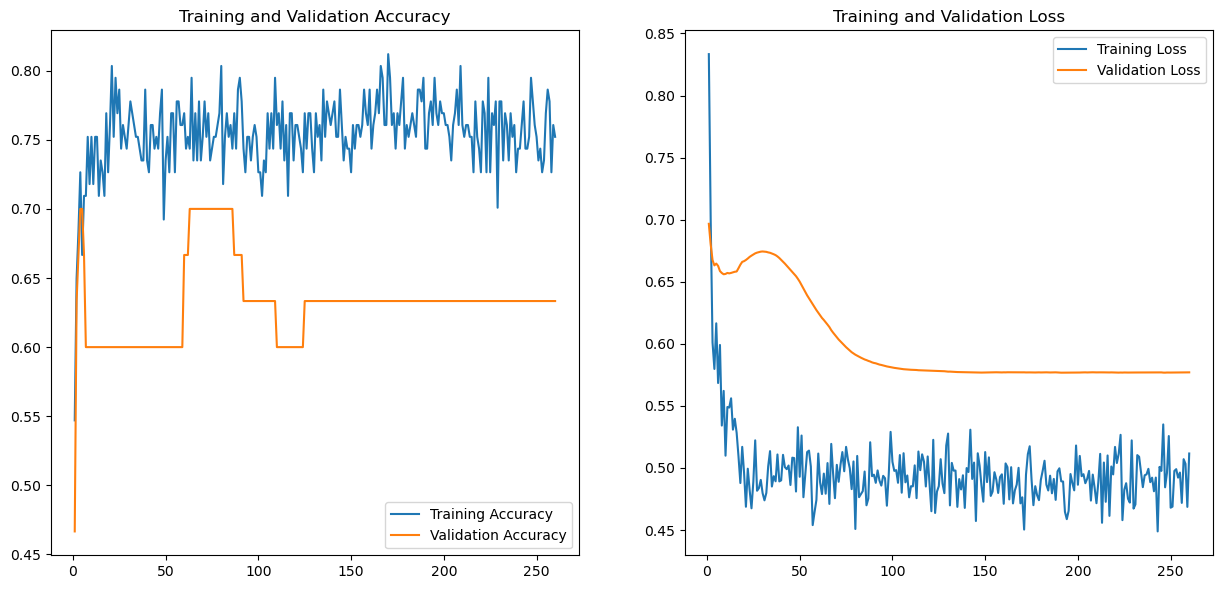

Validation accuracy: 0.633
Epoch 1/260
6/6 [==============================] - 2s 165ms/step - loss: 0.9070 - accuracy: 0.4188 - val_loss: 0.6759 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 101ms/step - loss: 0.7169 - accuracy: 0.6325 - val_loss: 0.6840 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 99ms/step - loss: 0.6682 - accuracy: 0.6581 - val_loss: 0.6812 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 93ms/step - loss: 0.6724 - accuracy: 0.6752 - val_loss: 0.6806 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 95ms/step - loss: 0.5820 - accuracy: 0.7350 - val_loss: 0.6791 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 120ms/step - loss: 0.5757 - accuracy: 0.7094 - val_loss: 0.6781 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 1

Epoch 54/260
6/6 [==============================] - 1s 94ms/step - loss: 0.2989 - accuracy: 0.8889 - val_loss: 0.5739 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 55/260
6/6 [==============================] - 1s 99ms/step - loss: 0.2752 - accuracy: 0.9145 - val_loss: 0.5762 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 56/260
6/6 [==============================] - 1s 92ms/step - loss: 0.3403 - accuracy: 0.8632 - val_loss: 0.5755 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 57/260
6/6 [==============================] - 1s 101ms/step - loss: 0.3092 - accuracy: 0.8974 - val_loss: 0.5752 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 58/260
6/6 [==============================] - 1s 100ms/step - loss: 0.3073 - accuracy: 0.8632 - val_loss: 0.5876 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 59/260
6/6 [==============================] - 1s 142ms/step - loss: 0.2934 - accuracy: 0.8889 - val_loss: 0.5951 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 60/260
6/6 [==============================] - 1s 117ms/step

Epoch 106/260
6/6 [==============================] - 1s 120ms/step - loss: 0.2737 - accuracy: 0.8803 - val_loss: 0.6217 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 107/260
6/6 [==============================] - 1s 131ms/step - loss: 0.3205 - accuracy: 0.8462 - val_loss: 0.6217 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 108/260
6/6 [==============================] - 1s 106ms/step - loss: 0.2813 - accuracy: 0.8718 - val_loss: 0.6216 - val_accuracy: 0.6667 - lr: 1.0000e-09
Epoch 109/260
6/6 [==============================] - 1s 104ms/step - loss: 0.2183 - accuracy: 0.9316 - val_loss: 0.6214 - val_accuracy: 0.6667 - lr: 1.0000e-09
Epoch 110/260
6/6 [==============================] - 1s 143ms/step - loss: 0.2557 - accuracy: 0.8974 - val_loss: 0.6214 - val_accuracy: 0.6667 - lr: 1.0000e-09
Epoch 111/260
6/6 [==============================] - 1s 131ms/step - loss: 0.2966 - accuracy: 0.8718 - val_loss: 0.6216 - val_accuracy: 0.6667 - lr: 1.0000e-09
Epoch 112/260
6/6 [=====================

6/6 [==============================] - 1s 180ms/step - loss: 0.2426 - accuracy: 0.8803 - val_loss: 0.6239 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 158/260
6/6 [==============================] - 1s 126ms/step - loss: 0.2500 - accuracy: 0.8889 - val_loss: 0.6240 - val_accuracy: 0.6667 - lr: 1.0000e-14
Epoch 159/260
6/6 [==============================] - 1s 95ms/step - loss: 0.2548 - accuracy: 0.9060 - val_loss: 0.6240 - val_accuracy: 0.6667 - lr: 1.0000e-14
Epoch 160/260
6/6 [==============================] - 1s 87ms/step - loss: 0.2426 - accuracy: 0.9060 - val_loss: 0.6239 - val_accuracy: 0.6667 - lr: 1.0000e-14
Epoch 161/260
6/6 [==============================] - 1s 102ms/step - loss: 0.2698 - accuracy: 0.9145 - val_loss: 0.6237 - val_accuracy: 0.6667 - lr: 1.0000e-14
Epoch 162/260
6/6 [==============================] - 1s 100ms/step - loss: 0.2608 - accuracy: 0.9231 - val_loss: 0.6238 - val_accuracy: 0.6667 - lr: 1.0000e-14
Epoch 163/260
6/6 [==============================] - 1s 

6/6 [==============================] - 1s 121ms/step - loss: 0.2572 - accuracy: 0.9060 - val_loss: 0.6248 - val_accuracy: 0.6667 - lr: 1.0000e-19
Epoch 209/260
6/6 [==============================] - 1s 124ms/step - loss: 0.2598 - accuracy: 0.8974 - val_loss: 0.6247 - val_accuracy: 0.6667 - lr: 1.0000e-19
Epoch 210/260
6/6 [==============================] - 1s 135ms/step - loss: 0.2441 - accuracy: 0.8974 - val_loss: 0.6247 - val_accuracy: 0.6667 - lr: 1.0000e-19
Epoch 211/260
6/6 [==============================] - 1s 118ms/step - loss: 0.2485 - accuracy: 0.9231 - val_loss: 0.6247 - val_accuracy: 0.6667 - lr: 1.0000e-19
Epoch 212/260
6/6 [==============================] - 1s 112ms/step - loss: 0.3127 - accuracy: 0.8632 - val_loss: 0.6248 - val_accuracy: 0.6667 - lr: 1.0000e-19
Epoch 213/260
6/6 [==============================] - 1s 98ms/step - loss: 0.2314 - accuracy: 0.9402 - val_loss: 0.6248 - val_accuracy: 0.6667 - lr: 1.0000e-19
Epoch 214/260
6/6 [==============================] - 1s

6/6 [==============================] - 1s 146ms/step - loss: 0.2523 - accuracy: 0.8974 - val_loss: 0.6246 - val_accuracy: 0.6667 - lr: 1.0000e-24
Epoch 260/260
6/6 [==============================] - 1s 116ms/step - loss: 0.2753 - accuracy: 0.8803 - val_loss: 0.6248 - val_accuracy: 0.6667 - lr: 1.0000e-24


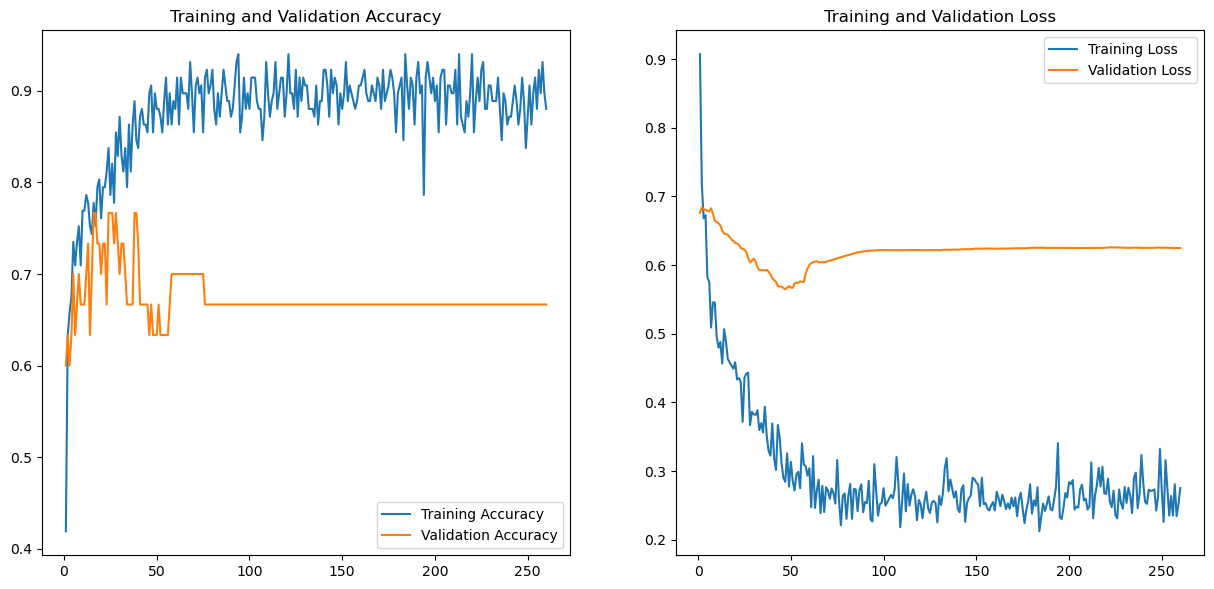

Validation accuracy: 0.667
Epoch 1/260
6/6 [==============================] - 3s 227ms/step - loss: 0.9670 - accuracy: 0.4957 - val_loss: 0.6906 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 146ms/step - loss: 0.7574 - accuracy: 0.6325 - val_loss: 0.6895 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 88ms/step - loss: 0.7057 - accuracy: 0.6410 - val_loss: 0.6878 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 118ms/step - loss: 0.6541 - accuracy: 0.6667 - val_loss: 0.6860 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 99ms/step - loss: 0.5894 - accuracy: 0.7009 - val_loss: 0.6835 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 130ms/step - loss: 0.6068 - accuracy: 0.6496 - val_loss: 0.6790 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 

Epoch 53/260
6/6 [==============================] - 1s 93ms/step - loss: 0.4457 - accuracy: 0.7863 - val_loss: 0.6517 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 54/260
6/6 [==============================] - 1s 112ms/step - loss: 0.4478 - accuracy: 0.8034 - val_loss: 0.6499 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 55/260
6/6 [==============================] - 1s 95ms/step - loss: 0.4561 - accuracy: 0.7521 - val_loss: 0.6484 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 56/260
6/6 [==============================] - 1s 95ms/step - loss: 0.4622 - accuracy: 0.7949 - val_loss: 0.6469 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 57/260
6/6 [==============================] - 1s 106ms/step - loss: 0.4538 - accuracy: 0.7778 - val_loss: 0.6450 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 58/260
6/6 [==============================] - 1s 134ms/step - loss: 0.4290 - accuracy: 0.8120 - val_loss: 0.6433 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 59/260
6/6 [==============================]

6/6 [==============================] - 1s 103ms/step - loss: 0.4086 - accuracy: 0.8034 - val_loss: 0.6191 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 105/260
6/6 [==============================] - 1s 119ms/step - loss: 0.4300 - accuracy: 0.7863 - val_loss: 0.6194 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 106/260
6/6 [==============================] - 1s 137ms/step - loss: 0.4285 - accuracy: 0.8205 - val_loss: 0.6198 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 107/260
6/6 [==============================] - 1s 130ms/step - loss: 0.4302 - accuracy: 0.7778 - val_loss: 0.6202 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 108/260
6/6 [==============================] - 1s 149ms/step - loss: 0.4399 - accuracy: 0.7863 - val_loss: 0.6206 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 109/260
6/6 [==============================] - 1s 141ms/step - loss: 0.4437 - accuracy: 0.7863 - val_loss: 0.6209 - val_accuracy: 0.7000 - lr: 1.0000e-06
Epoch 110/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 118ms/step - loss: 0.4386 - accuracy: 0.7863 - val_loss: 0.6310 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 156/260
6/6 [==============================] - 1s 111ms/step - loss: 0.4148 - accuracy: 0.7863 - val_loss: 0.6310 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 157/260
6/6 [==============================] - 1s 135ms/step - loss: 0.4183 - accuracy: 0.7949 - val_loss: 0.6311 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 158/260
6/6 [==============================] - 1s 142ms/step - loss: 0.4366 - accuracy: 0.7863 - val_loss: 0.6312 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 159/260
6/6 [==============================] - 1s 139ms/step - loss: 0.4016 - accuracy: 0.8034 - val_loss: 0.6312 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 160/260
6/6 [==============================] - 1s 141ms/step - loss: 0.4074 - accuracy: 0.7863 - val_loss: 0.6313 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 161/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 134ms/step - loss: 0.4261 - accuracy: 0.7778 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-15
Epoch 207/260
6/6 [==============================] - 1s 112ms/step - loss: 0.4349 - accuracy: 0.7692 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-15
Epoch 208/260
6/6 [==============================] - 1s 100ms/step - loss: 0.4325 - accuracy: 0.7949 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-15
Epoch 209/260
6/6 [==============================] - 1s 137ms/step - loss: 0.4535 - accuracy: 0.7863 - val_loss: 0.6322 - val_accuracy: 0.6000 - lr: 1.0000e-16
Epoch 210/260
6/6 [==============================] - 1s 137ms/step - loss: 0.3953 - accuracy: 0.8120 - val_loss: 0.6322 - val_accuracy: 0.6000 - lr: 1.0000e-16
Epoch 211/260
6/6 [==============================] - 1s 127ms/step - loss: 0.4300 - accuracy: 0.7692 - val_loss: 0.6322 - val_accuracy: 0.6000 - lr: 1.0000e-16
Epoch 212/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 105ms/step - loss: 0.4324 - accuracy: 0.7692 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-20
Epoch 258/260
6/6 [==============================] - 1s 130ms/step - loss: 0.4250 - accuracy: 0.7778 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-20
Epoch 259/260
6/6 [==============================] - 1s 131ms/step - loss: 0.4504 - accuracy: 0.7863 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-21
Epoch 260/260
6/6 [==============================] - 1s 143ms/step - loss: 0.4362 - accuracy: 0.8120 - val_loss: 0.6321 - val_accuracy: 0.6000 - lr: 1.0000e-21


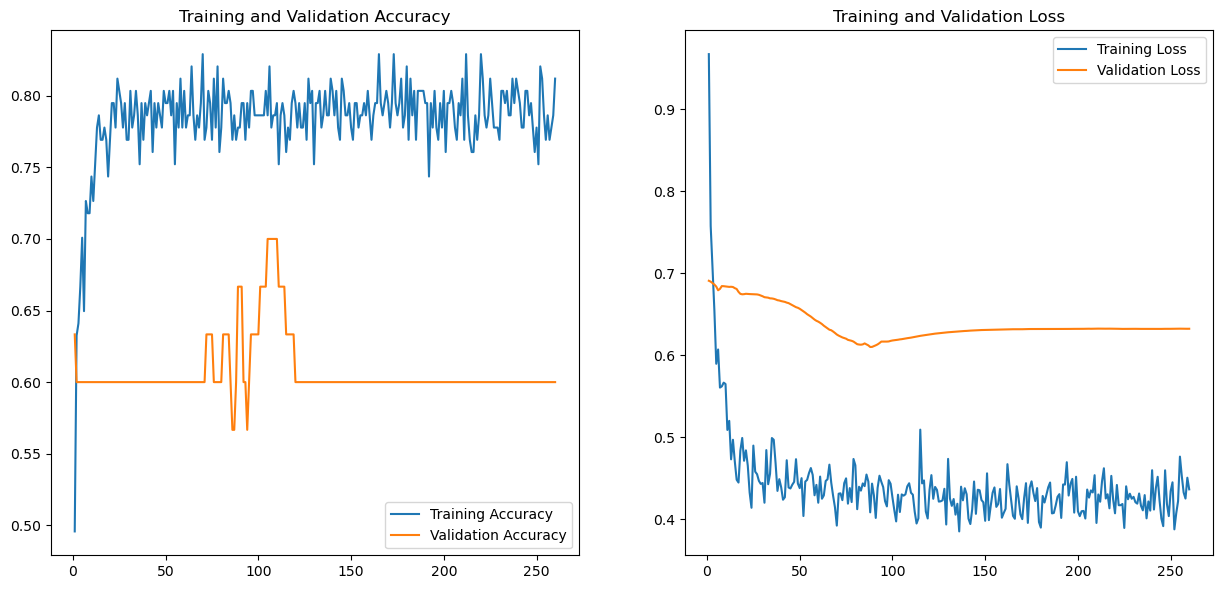

Validation accuracy: 0.600
Epoch 1/260
6/6 [==============================] - 2s 228ms/step - loss: 1.0494 - accuracy: 0.6752 - val_loss: 0.6900 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 110ms/step - loss: 0.8328 - accuracy: 0.5812 - val_loss: 0.6949 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 142ms/step - loss: 0.7178 - accuracy: 0.5983 - val_loss: 0.6892 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 116ms/step - loss: 0.6476 - accuracy: 0.6667 - val_loss: 0.6800 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 125ms/step - loss: 0.6165 - accuracy: 0.6496 - val_loss: 0.6736 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 123ms/step - loss: 0.5927 - accuracy: 0.6410 - val_loss: 0.6670 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] 

Epoch 53/260
6/6 [==============================] - 1s 118ms/step - loss: 0.5127 - accuracy: 0.7265 - val_loss: 0.6576 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 54/260
6/6 [==============================] - 1s 143ms/step - loss: 0.5158 - accuracy: 0.7521 - val_loss: 0.6561 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 55/260
6/6 [==============================] - 1s 132ms/step - loss: 0.5299 - accuracy: 0.7607 - val_loss: 0.6545 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 56/260
6/6 [==============================] - 1s 130ms/step - loss: 0.5213 - accuracy: 0.7350 - val_loss: 0.6529 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 57/260
6/6 [==============================] - 1s 140ms/step - loss: 0.5100 - accuracy: 0.7094 - val_loss: 0.6512 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 58/260
6/6 [==============================] - 1s 150ms/step - loss: 0.5308 - accuracy: 0.7521 - val_loss: 0.6493 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 59/260
6/6 [============================

6/6 [==============================] - 1s 164ms/step - loss: 0.5364 - accuracy: 0.7094 - val_loss: 0.6007 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 105/260
6/6 [==============================] - 1s 158ms/step - loss: 0.5120 - accuracy: 0.7436 - val_loss: 0.6008 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 106/260
6/6 [==============================] - 1s 256ms/step - loss: 0.5362 - accuracy: 0.7265 - val_loss: 0.6007 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 107/260
6/6 [==============================] - 1s 194ms/step - loss: 0.5231 - accuracy: 0.7350 - val_loss: 0.6007 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 108/260
6/6 [==============================] - 1s 175ms/step - loss: 0.5050 - accuracy: 0.7436 - val_loss: 0.6007 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 109/260
6/6 [==============================] - 1s 165ms/step - loss: 0.5489 - accuracy: 0.7265 - val_loss: 0.6007 - val_accuracy: 0.6333 - lr: 1.0000e-07
Epoch 110/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 100ms/step - loss: 0.5199 - accuracy: 0.7265 - val_loss: 0.5982 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 156/260
6/6 [==============================] - 1s 108ms/step - loss: 0.5234 - accuracy: 0.7521 - val_loss: 0.5982 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 157/260
6/6 [==============================] - 1s 187ms/step - loss: 0.5090 - accuracy: 0.7436 - val_loss: 0.5981 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 158/260
6/6 [==============================] - 1s 141ms/step - loss: 0.5290 - accuracy: 0.7179 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 159/260
6/6 [==============================] - 1s 107ms/step - loss: 0.5082 - accuracy: 0.7778 - val_loss: 0.5979 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 160/260
6/6 [==============================] - 1s 111ms/step - loss: 0.5367 - accuracy: 0.7179 - val_loss: 0.5979 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 161/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 86ms/step - loss: 0.5025 - accuracy: 0.7949 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-10
Epoch 207/260
6/6 [==============================] - 1s 107ms/step - loss: 0.5179 - accuracy: 0.7607 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 208/260
6/6 [==============================] - 1s 96ms/step - loss: 0.5380 - accuracy: 0.7350 - val_loss: 0.5979 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 209/260
6/6 [==============================] - 1s 92ms/step - loss: 0.5150 - accuracy: 0.7521 - val_loss: 0.5979 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 210/260
6/6 [==============================] - 1s 94ms/step - loss: 0.5277 - accuracy: 0.7265 - val_loss: 0.5979 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 211/260
6/6 [==============================] - 1s 88ms/step - loss: 0.5391 - accuracy: 0.7350 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-11
Epoch 212/260
6/6 [==============================] - 1s 95m

6/6 [==============================] - 1s 124ms/step - loss: 0.5316 - accuracy: 0.7692 - val_loss: 0.5979 - val_accuracy: 0.6000 - lr: 1.0000e-16
Epoch 258/260
6/6 [==============================] - 1s 164ms/step - loss: 0.5279 - accuracy: 0.7265 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-16
Epoch 259/260
6/6 [==============================] - 1s 136ms/step - loss: 0.5143 - accuracy: 0.7863 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-16
Epoch 260/260
6/6 [==============================] - 1s 130ms/step - loss: 0.5343 - accuracy: 0.7094 - val_loss: 0.5980 - val_accuracy: 0.6000 - lr: 1.0000e-16


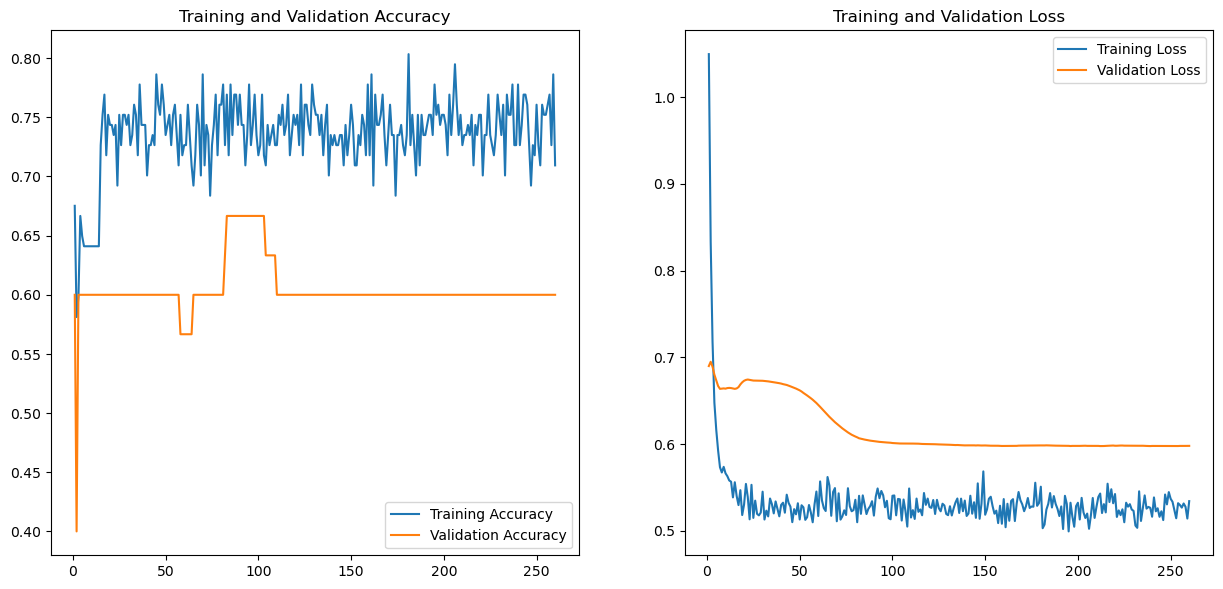

Validation accuracy: 0.600
Epoch 1/260
6/6 [==============================] - 3s 288ms/step - loss: 0.8264 - accuracy: 0.6154 - val_loss: 0.6880 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 152ms/step - loss: 0.6152 - accuracy: 0.7009 - val_loss: 0.6835 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 138ms/step - loss: 0.5969 - accuracy: 0.7179 - val_loss: 0.6791 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 128ms/step - loss: 0.5615 - accuracy: 0.7179 - val_loss: 0.6753 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 122ms/step - loss: 0.6000 - accuracy: 0.6581 - val_loss: 0.6733 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 138ms/step - loss: 0.5319 - accuracy: 0.7778 - val_loss: 0.6726 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] 

6/6 [==============================] - 1s 159ms/step - loss: 0.3641 - accuracy: 0.8376 - val_loss: 0.6668 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 54/260
6/6 [==============================] - 1s 179ms/step - loss: 0.3319 - accuracy: 0.8376 - val_loss: 0.6684 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 55/260
6/6 [==============================] - 1s 137ms/step - loss: 0.3525 - accuracy: 0.8462 - val_loss: 0.6689 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 56/260
6/6 [==============================] - 1s 129ms/step - loss: 0.3653 - accuracy: 0.8632 - val_loss: 0.6682 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 57/260
6/6 [==============================] - 1s 123ms/step - loss: 0.3172 - accuracy: 0.8803 - val_loss: 0.6675 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 58/260
6/6 [==============================] - 1s 140ms/step - loss: 0.2909 - accuracy: 0.8889 - val_loss: 0.6671 - val_accuracy: 0.6000 - lr: 1.0000e-05
Epoch 59/260
6/6 [==============================] - 1s 151m

6/6 [==============================] - 1s 122ms/step - loss: 0.2990 - accuracy: 0.8718 - val_loss: 0.6328 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 105/260
6/6 [==============================] - 1s 143ms/step - loss: 0.2985 - accuracy: 0.8889 - val_loss: 0.6318 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 106/260
6/6 [==============================] - 1s 143ms/step - loss: 0.3487 - accuracy: 0.8889 - val_loss: 0.6298 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 107/260
6/6 [==============================] - 1s 142ms/step - loss: 0.3327 - accuracy: 0.8803 - val_loss: 0.6272 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 108/260
6/6 [==============================] - 1s 133ms/step - loss: 0.3192 - accuracy: 0.8462 - val_loss: 0.6249 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 109/260
6/6 [==============================] - 1s 137ms/step - loss: 0.2964 - accuracy: 0.8803 - val_loss: 0.6227 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 110/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 113ms/step - loss: 0.3222 - accuracy: 0.8718 - val_loss: 0.5787 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 156/260
6/6 [==============================] - 1s 96ms/step - loss: 0.3146 - accuracy: 0.9145 - val_loss: 0.5791 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 157/260
6/6 [==============================] - 1s 120ms/step - loss: 0.3089 - accuracy: 0.8632 - val_loss: 0.5790 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 158/260
6/6 [==============================] - 1s 98ms/step - loss: 0.3070 - accuracy: 0.8889 - val_loss: 0.5784 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 159/260
6/6 [==============================] - 1s 106ms/step - loss: 0.3180 - accuracy: 0.8632 - val_loss: 0.5782 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 160/260
6/6 [==============================] - 1s 95ms/step - loss: 0.3090 - accuracy: 0.8632 - val_loss: 0.5783 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 161/260
6/6 [==============================] - 1s 9

6/6 [==============================] - 1s 87ms/step - loss: 0.3180 - accuracy: 0.8889 - val_loss: 0.5750 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 207/260
6/6 [==============================] - 1s 105ms/step - loss: 0.3289 - accuracy: 0.8547 - val_loss: 0.5750 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 208/260
6/6 [==============================] - 1s 90ms/step - loss: 0.3213 - accuracy: 0.8376 - val_loss: 0.5751 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 209/260
6/6 [==============================] - 1s 94ms/step - loss: 0.3208 - accuracy: 0.8803 - val_loss: 0.5752 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 210/260
6/6 [==============================] - 1s 96ms/step - loss: 0.3145 - accuracy: 0.8803 - val_loss: 0.5751 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 211/260
6/6 [==============================] - 1s 113ms/step - loss: 0.3046 - accuracy: 0.8889 - val_loss: 0.5751 - val_accuracy: 0.7000 - lr: 1.0000e-07
Epoch 212/260
6/6 [==============================] - 1s 95

6/6 [==============================] - 1s 101ms/step - loss: 0.3440 - accuracy: 0.8718 - val_loss: 0.5749 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 258/260
6/6 [==============================] - 1s 96ms/step - loss: 0.2970 - accuracy: 0.8547 - val_loss: 0.5749 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 259/260
6/6 [==============================] - 1s 99ms/step - loss: 0.3053 - accuracy: 0.8632 - val_loss: 0.5748 - val_accuracy: 0.7000 - lr: 1.0000e-11
Epoch 260/260
6/6 [==============================] - 1s 102ms/step - loss: 0.3380 - accuracy: 0.8803 - val_loss: 0.5748 - val_accuracy: 0.7000 - lr: 1.0000e-11


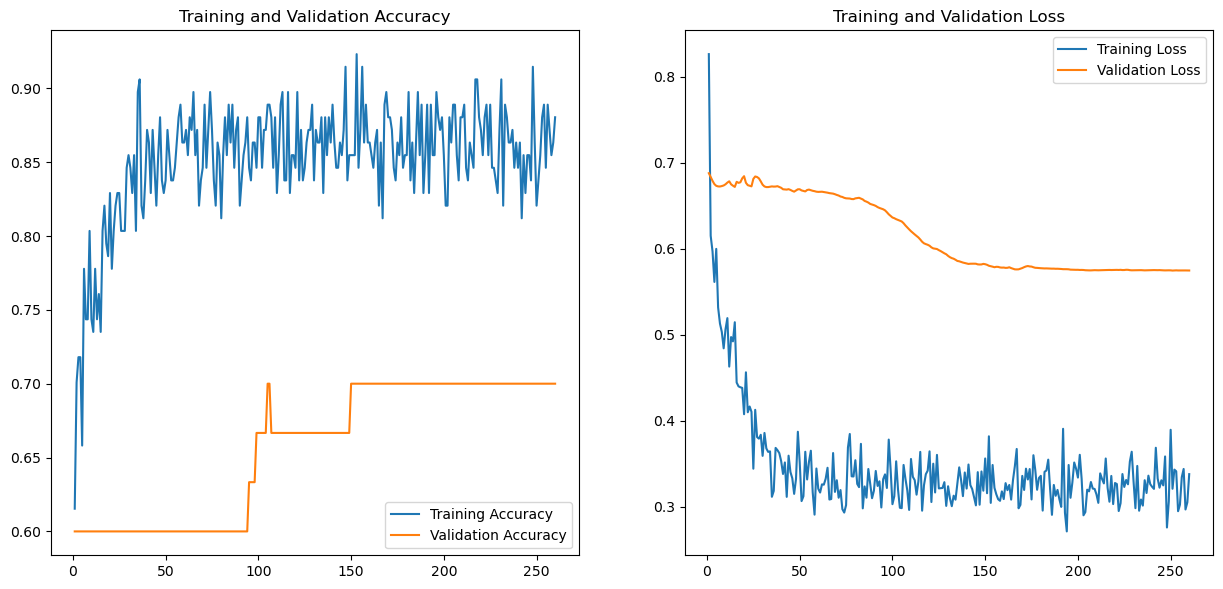

Validation accuracy: 0.700


In [10]:
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
acc_o = []
for i in range(10):
    model_o = cnn_o()
    learning_rate = 0.001
    model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])
    train_o = model_o.fit(X_train_o, Y_train_o,
                         batch_size = batch_size,
                         epochs = 260, 
                         verbose = 1,
                         validation_data = (X_val_o, Y_val_o),
                         callbacks = [reduce_on_plateau])
    acc = train_o.history['accuracy']
    val_acc = train_o.history['val_accuracy']
    loss = train_o.history['loss']
    val_loss = train_o.history['val_loss']

    epochs_range = range(1, len(acc)+1)

    #Train and validation accuracy 
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    #Train and validation loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o.append(val_acc)

In [11]:
media_o = np.mean(acc_o)
std_o = np.std(acc_o)
print(media_o)
print(std_o)   

0.6600000083446502
0.046666657924654


In [12]:
def cnn_o_aug(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(6, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [13]:
model_o_aug = cnn_o_aug()
model_o_aug.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 125, 125, 6)       60        
                                                                 
 batch_normalization_33 (Bat  (None, 125, 125, 6)      24        
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 125, 125, 6)       0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 60, 60, 6)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 60, 60, 6)         0         
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 8)       

In [14]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'training')
aug_val_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'validation')

Epoch 1/260
4/4 [==============================] - 2s 329ms/step - loss: 0.8389 - accuracy: 0.6441 - val_loss: 0.6944 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 226ms/step - loss: 0.7421 - accuracy: 0.5508 - val_loss: 0.6932 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 272ms/step - loss: 0.7325 - accuracy: 0.5763 - val_loss: 0.6864 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 225ms/step - loss: 0.6249 - accuracy: 0.6356 - val_loss: 0.6805 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 284ms/step - loss: 0.6787 - accuracy: 0.6525 - val_loss: 0.6846 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 219ms/step - loss: 0.6423 - accuracy: 0.6610 - val_loss: 0.6866 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 7/260
4/4 [==============================] - 1s 267ms/step - loss: 0.6

Epoch 53/260
4/4 [==============================] - 1s 312ms/step - loss: 0.5665 - accuracy: 0.6864 - val_loss: 0.7603 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 295ms/step - loss: 0.5671 - accuracy: 0.7288 - val_loss: 0.7638 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 284ms/step - loss: 0.5769 - accuracy: 0.7203 - val_loss: 0.7729 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 56/260
4/4 [==============================] - 1s 276ms/step - loss: 0.5730 - accuracy: 0.7203 - val_loss: 0.7617 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 57/260
4/4 [==============================] - 1s 252ms/step - loss: 0.5708 - accuracy: 0.6864 - val_loss: 0.7782 - val_accuracy: 0.5517 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 1s 250ms/step - loss: 0.5738 - accuracy: 0.6864 - val_loss: 0.7808 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 270ms/step - loss: 0.5654 - accuracy: 0.7119 - val_loss: 0.7522 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 252ms/step - loss: 0.5740 - accuracy: 0.6864 - val_loss: 0.7429 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 106/260
4/4 [==============================] - 1s 251ms/step - loss: 0.5686 - accuracy: 0.7119 - val_loss: 0.7553 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 107/260
4/4 [==============================] - 1s 278ms/step - loss: 0.5873 - accuracy: 0.6949 - val_loss: 0.7484 - val_accuracy: 0.4828 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 269ms/step - loss: 0.5907 - accuracy: 0.7119 - val_loss: 0.7468 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 279ms/step - loss: 0.6035 - accuracy: 0.6610 - val_loss: 0.7352 - val_accuracy: 0.5517 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 262ms/step - loss: 0.6055 - accuracy: 0.6780 - val_loss: 0.6785 - val_accuracy: 0.6207 - lr: 1.0000e-18
Epoch 156/260
4/4 [==============================] - 1s 257ms/step - loss: 0.5872 - accuracy: 0.7119 - val_loss: 0.7037 - val_accuracy: 0.6207 - lr: 1.0000e-18
Epoch 157/260
4/4 [==============================] - 1s 301ms/step - loss: 0.5899 - accuracy: 0.6864 - val_loss: 0.6945 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 1s 290ms/step - loss: 0.5373 - accuracy: 0.7627 - val_loss: 0.7048 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 268ms/step - loss: 0.5811 - accuracy: 0.7203 - val_loss: 0.7150 - val_accuracy: 0.6207 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 276ms/step - loss: 0.5706 - accuracy: 0.7203 - val_loss: 0.7003 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 263ms/step - loss: 0.5808 - accuracy: 0.7373 - val_loss: 0.6804 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 255ms/step - loss: 0.5899 - accuracy: 0.6780 - val_loss: 0.6813 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 255ms/step - loss: 0.5840 - accuracy: 0.7034 - val_loss: 0.7262 - val_accuracy: 0.5517 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 260ms/step - loss: 0.5827 - accuracy: 0.7119 - val_loss: 0.7107 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 1s 218ms/step - loss: 0.5959 - accuracy: 0.6864 - val_loss: 0.6966 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 1s 260ms/step - loss: 0.5790 - accuracy: 0.6695 - val_loss: 0.6686 - val_accuracy: 0.6552 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 255ms/step - loss: 0.5861 - accuracy: 0.7034 - val_loss: 0.7044 - val_accuracy: 0.5517 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 268ms/step - loss: 0.5699 - accuracy: 0.6695 - val_loss: 0.7340 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 259/260
4/4 [==============================] - 1s 273ms/step - loss: 0.5762 - accuracy: 0.7034 - val_loss: 0.7205 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 260/260
4/4 [==============================] - 1s 286ms/step - loss: 0.5905 - accuracy: 0.7119 - val_loss: 0.6785 - val_accuracy: 0.5862 - lr: 1.0000e-27


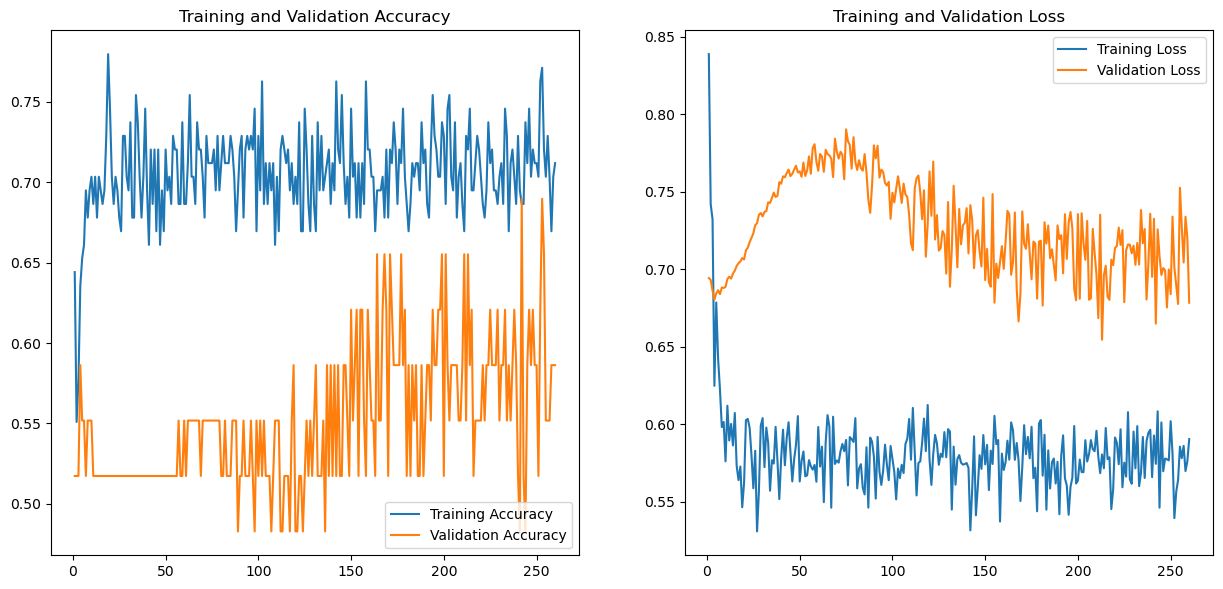

Validation accuracy: 0.621
Epoch 1/260
4/4 [==============================] - 2s 365ms/step - loss: 0.9523 - accuracy: 0.4237 - val_loss: 0.6939 - val_accuracy: 0.3793 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 217ms/step - loss: 0.7393 - accuracy: 0.6525 - val_loss: 0.6945 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 281ms/step - loss: 0.7130 - accuracy: 0.6271 - val_loss: 0.6945 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 259ms/step - loss: 0.6632 - accuracy: 0.6356 - val_loss: 0.6944 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 235ms/step - loss: 0.6788 - accuracy: 0.6525 - val_loss: 0.6949 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 235ms/step - loss: 0.6332 - accuracy: 0.6356 - val_loss: 0.6933 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 221ms/step - loss: 0.5582 - accuracy: 0.6610 - val_loss: 0.8196 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 235ms/step - loss: 0.6147 - accuracy: 0.6525 - val_loss: 0.8235 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 242ms/step - loss: 0.5836 - accuracy: 0.6610 - val_loss: 0.8241 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 1s 217ms/step - loss: 0.6058 - accuracy: 0.6610 - val_loss: 0.8165 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 1s 225ms/step - loss: 0.5819 - accuracy: 0.6695 - val_loss: 0.8225 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 1s 243ms/step - loss: 0.5971 - accuracy: 0.6610 - val_loss: 0.8235 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 238ms/step - loss: 0.5584 - accuracy: 0.6695 - val_loss: 0.7999 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 239ms/step - loss: 0.5809 - accuracy: 0.6610 - val_loss: 0.8229 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 261ms/step - loss: 0.5730 - accuracy: 0.6610 - val_loss: 0.8420 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 1s 235ms/step - loss: 0.5902 - accuracy: 0.6610 - val_loss: 0.8558 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 256ms/step - loss: 0.6018 - accuracy: 0.6610 - val_loss: 0.8256 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 301ms/step - loss: 0.5906 - accuracy: 0.6610 - val_loss: 0.8403 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 258ms/step - loss: 0.6152 - accuracy: 0.6695 - val_loss: 0.7628 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 231ms/step - loss: 0.5737 - accuracy: 0.6695 - val_loss: 0.7184 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 278ms/step - loss: 0.6011 - accuracy: 0.6610 - val_loss: 0.7262 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 1s 276ms/step - loss: 0.5879 - accuracy: 0.6610 - val_loss: 0.7511 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 249ms/step - loss: 0.5799 - accuracy: 0.6610 - val_loss: 0.7515 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 289ms/step - loss: 0.5844 - accuracy: 0.6610 - val_loss: 0.7401 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 262ms/step - loss: 0.5778 - accuracy: 0.6610 - val_loss: 0.6988 - val_accuracy: 0.5172 - lr: 1.0000e-21
Epoch 207/260
4/4 [==============================] - 1s 252ms/step - loss: 0.5752 - accuracy: 0.6610 - val_loss: 0.6961 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 271ms/step - loss: 0.5678 - accuracy: 0.6610 - val_loss: 0.7163 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 263ms/step - loss: 0.5729 - accuracy: 0.6610 - val_loss: 0.7082 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 210/260
4/4 [==============================] - 1s 270ms/step - loss: 0.5774 - accuracy: 0.6610 - val_loss: 0.7014 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 211/260
4/4 [==============================] - 1s 242ms/step - loss: 0.5761 - accuracy: 0.6610 - val_loss: 0.6909 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 233ms/step - loss: 0.6198 - accuracy: 0.6610 - val_loss: 0.7330 - val_accuracy: 0.5172 - lr: 1.0000e-26
Epoch 258/260
4/4 [==============================] - 1s 213ms/step - loss: 0.5683 - accuracy: 0.6610 - val_loss: 0.7269 - val_accuracy: 0.5172 - lr: 1.0000e-26
Epoch 259/260
4/4 [==============================] - 1s 288ms/step - loss: 0.5627 - accuracy: 0.6695 - val_loss: 0.7054 - val_accuracy: 0.5172 - lr: 1.0000e-26
Epoch 260/260
4/4 [==============================] - 1s 231ms/step - loss: 0.5992 - accuracy: 0.6610 - val_loss: 0.6987 - val_accuracy: 0.5172 - lr: 1.0000e-26


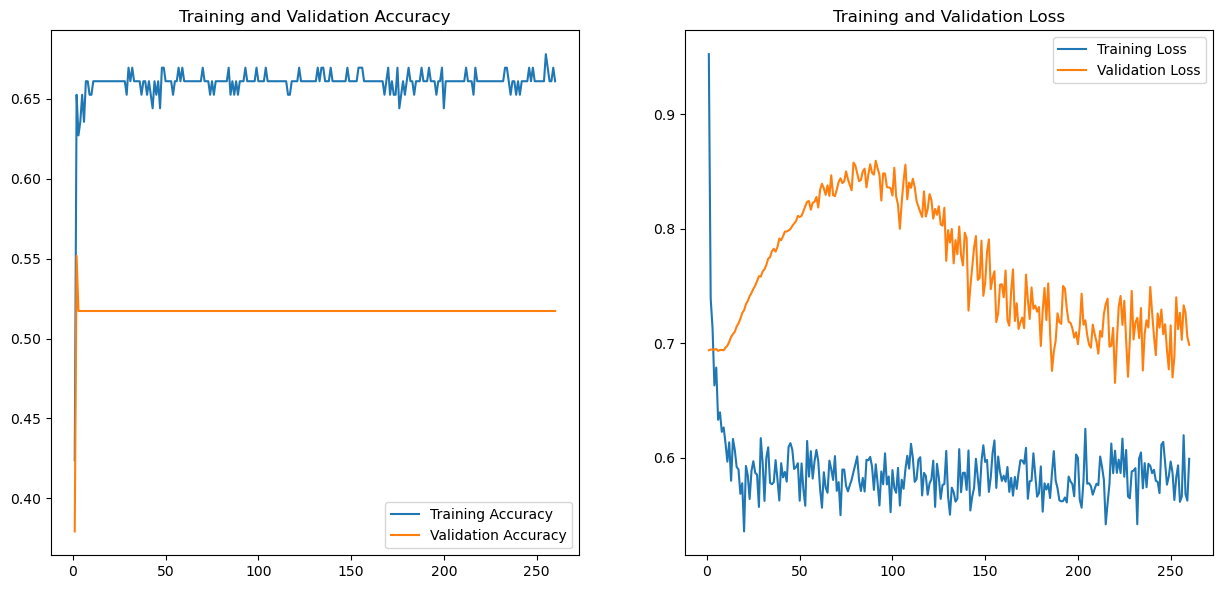

Validation accuracy: 0.517
Epoch 1/260
4/4 [==============================] - 2s 333ms/step - loss: 1.1224 - accuracy: 0.3983 - val_loss: 0.6981 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 278ms/step - loss: 0.9377 - accuracy: 0.6186 - val_loss: 0.6980 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 236ms/step - loss: 0.7698 - accuracy: 0.6441 - val_loss: 0.6919 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 263ms/step - loss: 0.7368 - accuracy: 0.6017 - val_loss: 0.6871 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 243ms/step - loss: 0.6789 - accuracy: 0.5847 - val_loss: 0.6890 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 241ms/step - loss: 0.5950 - accuracy: 0.7119 - val_loss: 0.6869 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 2s 368ms/step - loss: 0.5039 - accuracy: 0.7712 - val_loss: 0.7750 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 2s 456ms/step - loss: 0.5712 - accuracy: 0.7458 - val_loss: 0.7736 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 2s 416ms/step - loss: 0.5253 - accuracy: 0.7627 - val_loss: 0.7673 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 2s 403ms/step - loss: 0.5855 - accuracy: 0.7203 - val_loss: 0.7736 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 2s 462ms/step - loss: 0.5489 - accuracy: 0.7797 - val_loss: 0.7820 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 2s 456ms/step - loss: 0.5299 - accuracy: 0.7627 - val_loss: 0.7799 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 352ms/step - loss: 0.5680 - accuracy: 0.7288 - val_loss: 0.7965 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 326ms/step - loss: 0.5336 - accuracy: 0.7373 - val_loss: 0.7688 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 328ms/step - loss: 0.5979 - accuracy: 0.7119 - val_loss: 0.8026 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 1s 321ms/step - loss: 0.5371 - accuracy: 0.7542 - val_loss: 0.7483 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 308ms/step - loss: 0.5828 - accuracy: 0.7288 - val_loss: 0.7870 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 271ms/step - loss: 0.5538 - accuracy: 0.7627 - val_loss: 0.7624 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 317ms/step - loss: 0.5712 - accuracy: 0.6864 - val_loss: 0.7476 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 308ms/step - loss: 0.5439 - accuracy: 0.7542 - val_loss: 0.7752 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 305ms/step - loss: 0.5956 - accuracy: 0.7458 - val_loss: 0.7848 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 1s 313ms/step - loss: 0.5655 - accuracy: 0.7288 - val_loss: 0.7346 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 293ms/step - loss: 0.5804 - accuracy: 0.7373 - val_loss: 0.7187 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 345ms/step - loss: 0.5327 - accuracy: 0.7542 - val_loss: 0.7770 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 336ms/step - loss: 0.5575 - accuracy: 0.7627 - val_loss: 0.7503 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 2s 362ms/step - loss: 0.5542 - accuracy: 0.7627 - val_loss: 0.7215 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 331ms/step - loss: 0.5606 - accuracy: 0.7627 - val_loss: 0.7527 - val_accuracy: 0.5517 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 314ms/step - loss: 0.5522 - accuracy: 0.7373 - val_loss: 0.7426 - val_accuracy: 0.6207 - lr: 1.0000e-22
Epoch 210/260
4/4 [==============================] - 1s 337ms/step - loss: 0.5252 - accuracy: 0.7797 - val_loss: 0.7448 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 211/260
4/4 [==============================] - 1s 332ms/step - loss: 0.5672 - accuracy: 0.7542 - val_loss: 0.7405 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 302ms/step - loss: 0.5808 - accuracy: 0.7119 - val_loss: 0.7541 - val_accuracy: 0.6207 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 316ms/step - loss: 0.5476 - accuracy: 0.7288 - val_loss: 0.7100 - val_accuracy: 0.6207 - lr: 1.0000e-27
Epoch 259/260
4/4 [==============================] - 1s 330ms/step - loss: 0.5629 - accuracy: 0.7119 - val_loss: 0.8071 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 260/260
4/4 [==============================] - 2s 359ms/step - loss: 0.5984 - accuracy: 0.7373 - val_loss: 0.7688 - val_accuracy: 0.5172 - lr: 1.0000e-27


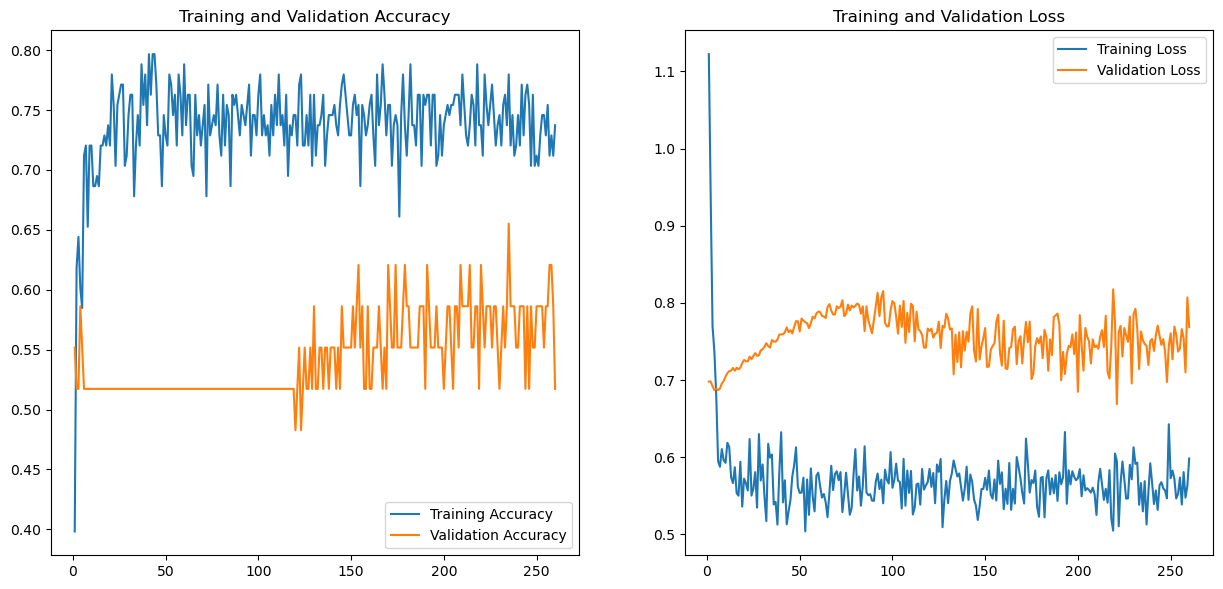

Validation accuracy: 0.552
Epoch 1/260
4/4 [==============================] - 4s 532ms/step - loss: 1.0050 - accuracy: 0.4746 - val_loss: 0.6924 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 332ms/step - loss: 0.7701 - accuracy: 0.6780 - val_loss: 0.6929 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 282ms/step - loss: 0.7105 - accuracy: 0.6780 - val_loss: 0.6928 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 300ms/step - loss: 0.6528 - accuracy: 0.6525 - val_loss: 0.6925 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 337ms/step - loss: 0.6929 - accuracy: 0.5169 - val_loss: 0.6922 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 329ms/step - loss: 0.5873 - accuracy: 0.7119 - val_loss: 0.6929 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 338ms/step - loss: 0.6160 - accuracy: 0.6780 - val_loss: 0.7965 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 274ms/step - loss: 0.5878 - accuracy: 0.7288 - val_loss: 0.7991 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 337ms/step - loss: 0.5923 - accuracy: 0.6949 - val_loss: 0.8022 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 1s 298ms/step - loss: 0.6315 - accuracy: 0.6864 - val_loss: 0.7996 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 57/260
4/4 [==============================] - 1s 277ms/step - loss: 0.6188 - accuracy: 0.6780 - val_loss: 0.7992 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 1s 322ms/step - loss: 0.6136 - accuracy: 0.7288 - val_loss: 0.8014 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 310ms/step - loss: 0.5996 - accuracy: 0.7203 - val_loss: 0.8032 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 277ms/step - loss: 0.6078 - accuracy: 0.6949 - val_loss: 0.7869 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 359ms/step - loss: 0.5889 - accuracy: 0.7034 - val_loss: 0.7908 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 107/260
4/4 [==============================] - 1s 295ms/step - loss: 0.5651 - accuracy: 0.7458 - val_loss: 0.7807 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 316ms/step - loss: 0.5880 - accuracy: 0.6780 - val_loss: 0.7897 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 316ms/step - loss: 0.6216 - accuracy: 0.6780 - val_loss: 0.7869 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 305ms/step - loss: 0.5983 - accuracy: 0.6780 - val_loss: 0.7680 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 275ms/step - loss: 0.5821 - accuracy: 0.6780 - val_loss: 0.7660 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 157/260
4/4 [==============================] - 1s 297ms/step - loss: 0.5806 - accuracy: 0.7203 - val_loss: 0.7793 - val_accuracy: 0.4828 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 1s 301ms/step - loss: 0.5925 - accuracy: 0.6949 - val_loss: 0.7647 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 344ms/step - loss: 0.6070 - accuracy: 0.7119 - val_loss: 0.7836 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 333ms/step - loss: 0.5887 - accuracy: 0.6780 - val_loss: 0.7683 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 359ms/step - loss: 0.5774 - accuracy: 0.6949 - val_loss: 0.7526 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 207/260
4/4 [==============================] - 1s 310ms/step - loss: 0.6197 - accuracy: 0.6525 - val_loss: 0.7541 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 208/260
4/4 [==============================] - 1s 333ms/step - loss: 0.6003 - accuracy: 0.6949 - val_loss: 0.7354 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 209/260
4/4 [==============================] - 1s 338ms/step - loss: 0.6214 - accuracy: 0.7288 - val_loss: 0.7453 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 1s 333ms/step - loss: 0.5718 - accuracy: 0.7034 - val_loss: 0.7497 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 1s 305ms/step - loss: 0.6016 - accuracy: 0.7119 - val_loss: 0.7404 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 322ms/step - loss: 0.6024 - accuracy: 0.6864 - val_loss: 0.7273 - val_accuracy: 0.5862 - lr: 1.0000e-28
Epoch 258/260
4/4 [==============================] - 1s 312ms/step - loss: 0.5990 - accuracy: 0.6949 - val_loss: 0.7471 - val_accuracy: 0.5517 - lr: 1.0000e-28
Epoch 259/260
4/4 [==============================] - 1s 315ms/step - loss: 0.6028 - accuracy: 0.6864 - val_loss: 0.7445 - val_accuracy: 0.5517 - lr: 1.0000e-28
Epoch 260/260
4/4 [==============================] - 1s 290ms/step - loss: 0.5902 - accuracy: 0.6949 - val_loss: 0.7660 - val_accuracy: 0.5172 - lr: 1.0000e-28


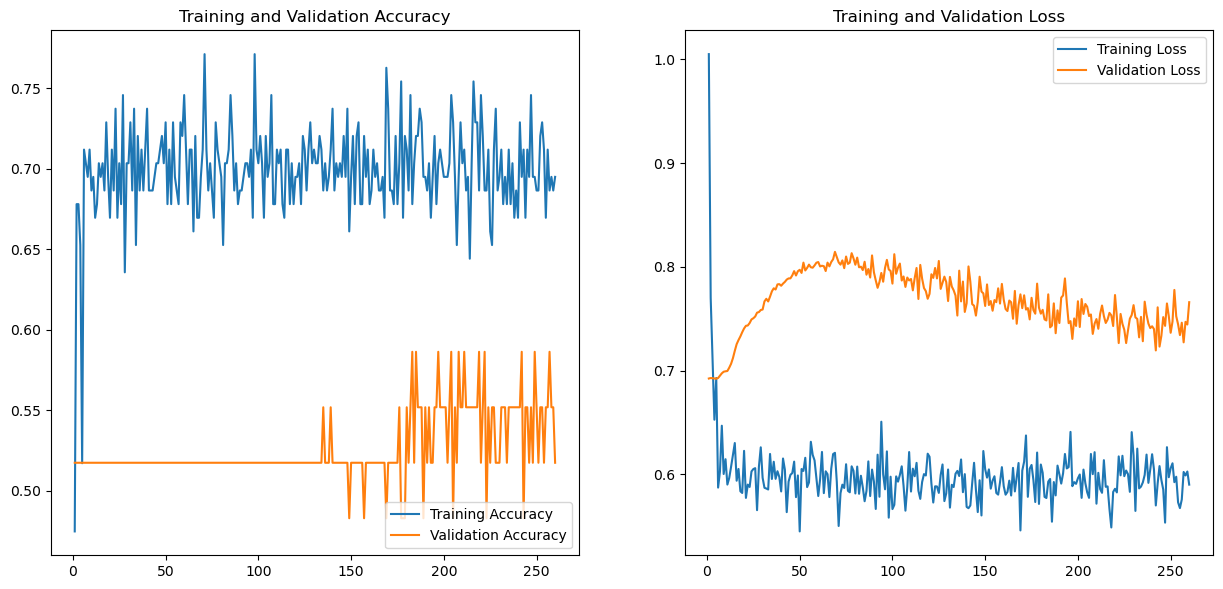

Validation accuracy: 0.552
Epoch 1/260
4/4 [==============================] - 5s 611ms/step - loss: 0.7139 - accuracy: 0.6186 - val_loss: 0.6855 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 314ms/step - loss: 0.7128 - accuracy: 0.6695 - val_loss: 0.6857 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 317ms/step - loss: 0.7031 - accuracy: 0.6780 - val_loss: 0.6819 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 315ms/step - loss: 0.5722 - accuracy: 0.7203 - val_loss: 0.6786 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 306ms/step - loss: 0.6352 - accuracy: 0.6780 - val_loss: 0.6826 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 2s 363ms/step - loss: 0.6191 - accuracy: 0.6695 - val_loss: 0.6981 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 291ms/step - loss: 0.5730 - accuracy: 0.7458 - val_loss: 0.8145 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 294ms/step - loss: 0.5433 - accuracy: 0.7712 - val_loss: 0.8163 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 346ms/step - loss: 0.5701 - accuracy: 0.7373 - val_loss: 0.8213 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 56/260
4/4 [==============================] - 1s 328ms/step - loss: 0.5651 - accuracy: 0.7373 - val_loss: 0.8187 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 57/260
4/4 [==============================] - 1s 311ms/step - loss: 0.5673 - accuracy: 0.7627 - val_loss: 0.8106 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 1s 277ms/step - loss: 0.5755 - accuracy: 0.7288 - val_loss: 0.8253 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 305ms/step - loss: 0.5546 - accuracy: 0.7712 - val_loss: 0.7920 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 2s 348ms/step - loss: 0.5448 - accuracy: 0.7203 - val_loss: 0.7909 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 106/260
4/4 [==============================] - 2s 359ms/step - loss: 0.5256 - accuracy: 0.7288 - val_loss: 0.8220 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 107/260
4/4 [==============================] - 1s 347ms/step - loss: 0.5621 - accuracy: 0.7034 - val_loss: 0.7942 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 310ms/step - loss: 0.5698 - accuracy: 0.7627 - val_loss: 0.8335 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 2s 373ms/step - loss: 0.5202 - accuracy: 0.7373 - val_loss: 0.8631 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 328ms/step - loss: 0.5765 - accuracy: 0.7288 - val_loss: 0.7397 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 156/260
4/4 [==============================] - 1s 314ms/step - loss: 0.5319 - accuracy: 0.7373 - val_loss: 0.7904 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 157/260
4/4 [==============================] - 1s 352ms/step - loss: 0.5376 - accuracy: 0.7458 - val_loss: 0.7536 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 1s 340ms/step - loss: 0.5613 - accuracy: 0.7203 - val_loss: 0.8064 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 2s 364ms/step - loss: 0.5709 - accuracy: 0.7797 - val_loss: 0.7901 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 316ms/step - loss: 0.5797 - accuracy: 0.7288 - val_loss: 0.7574 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 2s 365ms/step - loss: 0.5490 - accuracy: 0.7458 - val_loss: 0.7344 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 207/260
4/4 [==============================] - 1s 342ms/step - loss: 0.5669 - accuracy: 0.7288 - val_loss: 0.7761 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 208/260
4/4 [==============================] - 2s 350ms/step - loss: 0.5419 - accuracy: 0.7542 - val_loss: 0.7454 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 209/260
4/4 [==============================] - 1s 343ms/step - loss: 0.5154 - accuracy: 0.7627 - val_loss: 0.7297 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 2s 350ms/step - loss: 0.5255 - accuracy: 0.7458 - val_loss: 0.7483 - val_accuracy: 0.5862 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 1s 306ms/step - loss: 0.5559 - accuracy: 0.7288 - val_loss: 0.7373 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 319ms/step - loss: 0.5362 - accuracy: 0.7373 - val_loss: 0.8001 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 258/260
4/4 [==============================] - 2s 348ms/step - loss: 0.5658 - accuracy: 0.7203 - val_loss: 0.7110 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 259/260
4/4 [==============================] - 1s 345ms/step - loss: 0.5464 - accuracy: 0.7627 - val_loss: 0.7813 - val_accuracy: 0.5517 - lr: 1.0000e-28
Epoch 260/260
4/4 [==============================] - 1s 296ms/step - loss: 0.5526 - accuracy: 0.7458 - val_loss: 0.7907 - val_accuracy: 0.5862 - lr: 1.0000e-28


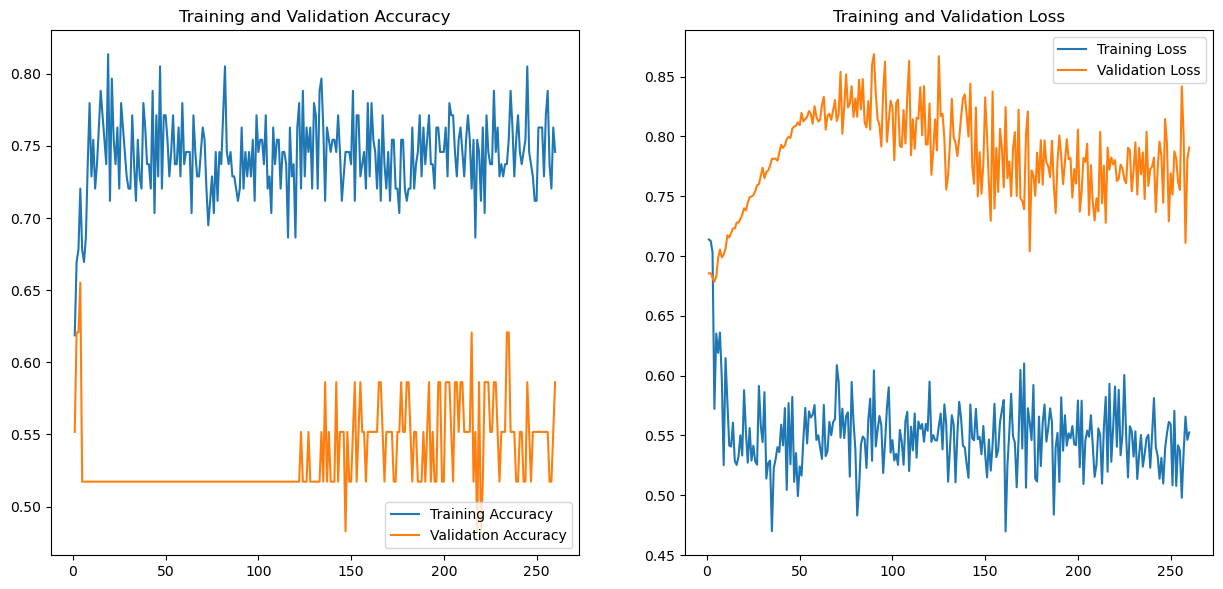

Validation accuracy: 0.552
Epoch 1/260
4/4 [==============================] - 4s 547ms/step - loss: 0.7970 - accuracy: 0.5678 - val_loss: 0.6924 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 2s 369ms/step - loss: 0.6115 - accuracy: 0.6949 - val_loss: 0.6919 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 2s 350ms/step - loss: 0.7151 - accuracy: 0.6102 - val_loss: 0.6971 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 350ms/step - loss: 0.5959 - accuracy: 0.6695 - val_loss: 0.6965 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 275ms/step - loss: 0.5169 - accuracy: 0.7288 - val_loss: 0.6935 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 300ms/step - loss: 0.6328 - accuracy: 0.6864 - val_loss: 0.6913 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 311ms/step - loss: 0.5703 - accuracy: 0.7034 - val_loss: 0.8345 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 2s 367ms/step - loss: 0.5231 - accuracy: 0.7288 - val_loss: 0.8216 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 2s 364ms/step - loss: 0.5277 - accuracy: 0.7542 - val_loss: 0.8910 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 1s 338ms/step - loss: 0.5437 - accuracy: 0.7203 - val_loss: 0.8508 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 1s 294ms/step - loss: 0.6018 - accuracy: 0.7119 - val_loss: 0.8405 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 1s 266ms/step - loss: 0.5491 - accuracy: 0.7542 - val_loss: 0.8395 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 278ms/step - loss: 0.5314 - accuracy: 0.7542 - val_loss: 0.7875 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 269ms/step - loss: 0.5772 - accuracy: 0.7542 - val_loss: 0.8050 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 233ms/step - loss: 0.5342 - accuracy: 0.7373 - val_loss: 0.7813 - val_accuracy: 0.5517 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 1s 256ms/step - loss: 0.5247 - accuracy: 0.7627 - val_loss: 0.7273 - val_accuracy: 0.5517 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 266ms/step - loss: 0.5322 - accuracy: 0.7542 - val_loss: 0.7794 - val_accuracy: 0.5517 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 250ms/step - loss: 0.5848 - accuracy: 0.6864 - val_loss: 0.7964 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 240ms/step - loss: 0.5510 - accuracy: 0.7627 - val_loss: 0.7291 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 236ms/step - loss: 0.5195 - accuracy: 0.7542 - val_loss: 0.7666 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 248ms/step - loss: 0.6004 - accuracy: 0.6949 - val_loss: 0.8221 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 1s 223ms/step - loss: 0.5566 - accuracy: 0.7203 - val_loss: 0.8012 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 286ms/step - loss: 0.5775 - accuracy: 0.6949 - val_loss: 0.8044 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 212ms/step - loss: 0.5526 - accuracy: 0.7119 - val_loss: 0.7850 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 267ms/step - loss: 0.5291 - accuracy: 0.7712 - val_loss: 0.7685 - val_accuracy: 0.5517 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 242ms/step - loss: 0.5299 - accuracy: 0.7288 - val_loss: 0.7666 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 208/260
4/4 [==============================] - 1s 279ms/step - loss: 0.5391 - accuracy: 0.7712 - val_loss: 0.7959 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 209/260
4/4 [==============================] - 1s 247ms/step - loss: 0.5713 - accuracy: 0.7034 - val_loss: 0.8145 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 1s 290ms/step - loss: 0.5183 - accuracy: 0.7288 - val_loss: 0.7586 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 1s 224ms/step - loss: 0.5699 - accuracy: 0.7373 - val_loss: 0.7963 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 227ms/step - loss: 0.5114 - accuracy: 0.7542 - val_loss: 0.7874 - val_accuracy: 0.5862 - lr: 1.0000e-28
Epoch 258/260
4/4 [==============================] - 1s 232ms/step - loss: 0.5276 - accuracy: 0.7712 - val_loss: 0.8003 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 259/260
4/4 [==============================] - 1s 272ms/step - loss: 0.5797 - accuracy: 0.7373 - val_loss: 0.7931 - val_accuracy: 0.5517 - lr: 1.0000e-28
Epoch 260/260
4/4 [==============================] - 1s 251ms/step - loss: 0.5283 - accuracy: 0.7627 - val_loss: 0.7536 - val_accuracy: 0.5172 - lr: 1.0000e-28


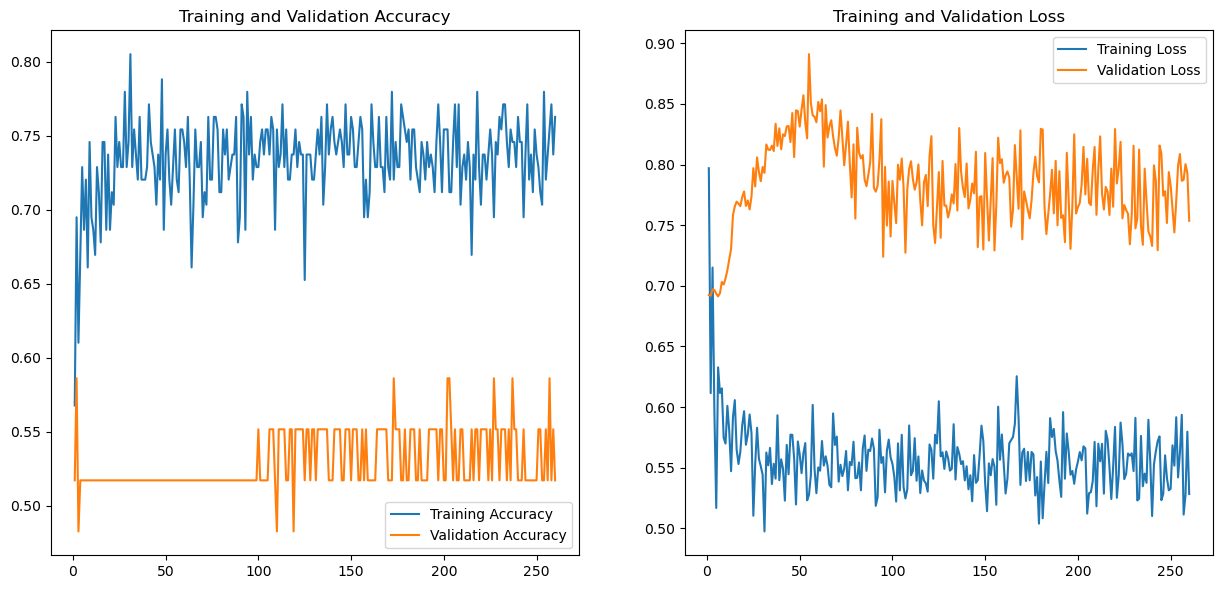

Validation accuracy: 0.517
Epoch 1/260
4/4 [==============================] - 2s 350ms/step - loss: 0.9232 - accuracy: 0.5763 - val_loss: 0.6897 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 263ms/step - loss: 0.7755 - accuracy: 0.5508 - val_loss: 0.6907 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 255ms/step - loss: 0.6800 - accuracy: 0.6356 - val_loss: 0.6887 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 260ms/step - loss: 0.6389 - accuracy: 0.6695 - val_loss: 0.6885 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 230ms/step - loss: 0.6397 - accuracy: 0.6949 - val_loss: 0.6881 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 257ms/step - loss: 0.6370 - accuracy: 0.6864 - val_loss: 0.6894 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 280ms/step - loss: 0.5653 - accuracy: 0.7288 - val_loss: 0.7805 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 233ms/step - loss: 0.5358 - accuracy: 0.7458 - val_loss: 0.7695 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 238ms/step - loss: 0.5966 - accuracy: 0.7119 - val_loss: 0.7674 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 1s 237ms/step - loss: 0.5739 - accuracy: 0.7119 - val_loss: 0.7845 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 1s 251ms/step - loss: 0.5468 - accuracy: 0.7034 - val_loss: 0.7661 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 58/260
4/4 [==============================] - 1s 282ms/step - loss: 0.5599 - accuracy: 0.7627 - val_loss: 0.7738 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 295ms/step - loss: 0.5901 - accuracy: 0.6780 - val_loss: 0.7581 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 234ms/step - loss: 0.5593 - accuracy: 0.7288 - val_loss: 0.8150 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 288ms/step - loss: 0.5298 - accuracy: 0.7627 - val_loss: 0.7780 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 1s 259ms/step - loss: 0.5408 - accuracy: 0.7542 - val_loss: 0.7885 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 108/260
4/4 [==============================] - 1s 227ms/step - loss: 0.5501 - accuracy: 0.7458 - val_loss: 0.7452 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 109/260
4/4 [==============================] - 1s 272ms/step - loss: 0.5510 - accuracy: 0.7288 - val_loss: 0.7732 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 245ms/step - loss: 0.5500 - accuracy: 0.7203 - val_loss: 0.7649 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 234ms/step - loss: 0.5545 - accuracy: 0.7034 - val_loss: 0.7777 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 247ms/step - loss: 0.5768 - accuracy: 0.7203 - val_loss: 0.7225 - val_accuracy: 0.4828 - lr: 1.0000e-17
Epoch 158/260
4/4 [==============================] - 1s 225ms/step - loss: 0.5513 - accuracy: 0.7288 - val_loss: 0.7738 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 159/260
4/4 [==============================] - 1s 271ms/step - loss: 0.5651 - accuracy: 0.7373 - val_loss: 0.7431 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 273ms/step - loss: 0.5624 - accuracy: 0.7119 - val_loss: 0.7480 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 271ms/step - loss: 0.5316 - accuracy: 0.7203 - val_loss: 0.7096 - val_accuracy: 0.4828 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 244ms/step - loss: 0.5741 - accuracy: 0.7288 - val_loss: 0.7862 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 239ms/step - loss: 0.5623 - accuracy: 0.7627 - val_loss: 0.7456 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 225ms/step - loss: 0.5346 - accuracy: 0.7627 - val_loss: 0.7081 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 1s 249ms/step - loss: 0.5671 - accuracy: 0.7034 - val_loss: 0.7485 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 1s 275ms/step - loss: 0.5711 - accuracy: 0.7458 - val_loss: 0.7669 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 282ms/step - loss: 0.5469 - accuracy: 0.7203 - val_loss: 0.7903 - val_accuracy: 0.5172 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 261ms/step - loss: 0.5642 - accuracy: 0.7203 - val_loss: 0.7030 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 259/260
4/4 [==============================] - 1s 266ms/step - loss: 0.5815 - accuracy: 0.6949 - val_loss: 0.6720 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 260/260
4/4 [==============================] - 1s 224ms/step - loss: 0.5388 - accuracy: 0.7712 - val_loss: 0.7193 - val_accuracy: 0.5862 - lr: 1.0000e-27


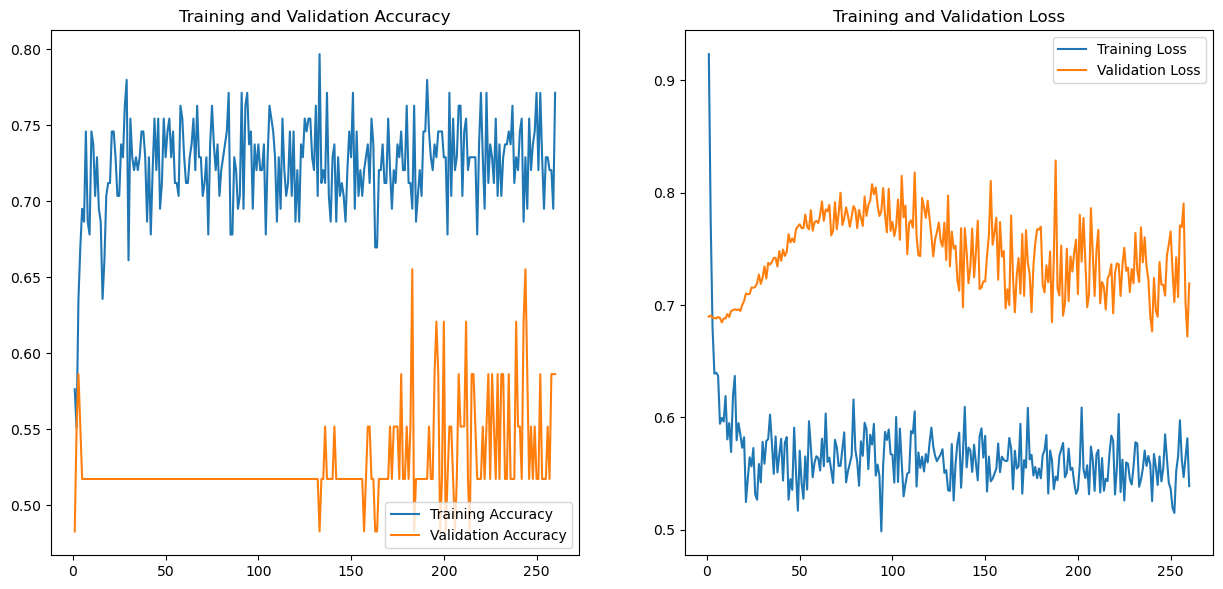

Validation accuracy: 0.621
Epoch 1/260
4/4 [==============================] - 2s 317ms/step - loss: 0.6958 - accuracy: 0.5763 - val_loss: 0.6932 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 217ms/step - loss: 0.6601 - accuracy: 0.5932 - val_loss: 0.6940 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 219ms/step - loss: 0.6369 - accuracy: 0.6695 - val_loss: 0.6932 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 260ms/step - loss: 0.6415 - accuracy: 0.6695 - val_loss: 0.6927 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 253ms/step - loss: 0.6026 - accuracy: 0.6695 - val_loss: 0.6906 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 258ms/step - loss: 0.6006 - accuracy: 0.6695 - val_loss: 0.6858 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 257ms/step - loss: 0.5515 - accuracy: 0.7712 - val_loss: 0.7008 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 289ms/step - loss: 0.5626 - accuracy: 0.7373 - val_loss: 0.7033 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 224ms/step - loss: 0.5590 - accuracy: 0.7458 - val_loss: 0.6985 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 1s 239ms/step - loss: 0.4959 - accuracy: 0.7881 - val_loss: 0.7103 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 1s 217ms/step - loss: 0.5319 - accuracy: 0.7627 - val_loss: 0.7047 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 58/260
4/4 [==============================] - 1s 241ms/step - loss: 0.5556 - accuracy: 0.7203 - val_loss: 0.7097 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 265ms/step - loss: 0.5639 - accuracy: 0.7627 - val_loss: 0.7019 - val_accuracy: 0.5517 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 271ms/step - loss: 0.5777 - accuracy: 0.7203 - val_loss: 0.6967 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 267ms/step - loss: 0.5505 - accuracy: 0.7373 - val_loss: 0.7053 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 1s 298ms/step - loss: 0.5195 - accuracy: 0.7881 - val_loss: 0.6951 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 108/260
4/4 [==============================] - 1s 260ms/step - loss: 0.5715 - accuracy: 0.7373 - val_loss: 0.6988 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 109/260
4/4 [==============================] - 1s 265ms/step - loss: 0.5445 - accuracy: 0.7373 - val_loss: 0.7078 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 311ms/step - loss: 0.5643 - accuracy: 0.7034 - val_loss: 0.6864 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 372ms/step - loss: 0.5362 - accuracy: 0.7712 - val_loss: 0.6698 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 290ms/step - loss: 0.5607 - accuracy: 0.7966 - val_loss: 0.6745 - val_accuracy: 0.6207 - lr: 1.0000e-17
Epoch 158/260
4/4 [==============================] - 1s 265ms/step - loss: 0.5753 - accuracy: 0.7203 - val_loss: 0.6676 - val_accuracy: 0.6207 - lr: 1.0000e-17
Epoch 159/260
4/4 [==============================] - 1s 260ms/step - loss: 0.5725 - accuracy: 0.7542 - val_loss: 0.7327 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 160/260
4/4 [==============================] - 1s 255ms/step - loss: 0.5495 - accuracy: 0.7119 - val_loss: 0.6886 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 273ms/step - loss: 0.6120 - accuracy: 0.7119 - val_loss: 0.7088 - val_accuracy: 0.5517 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 281ms/step - loss: 0.5692 - accuracy: 0.7203 - val_loss: 0.6757 - val_accuracy: 0.6207 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 274ms/step - loss: 0.5557 - accuracy: 0.7288 - val_loss: 0.6920 - val_accuracy: 0.6207 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 275ms/step - loss: 0.5451 - accuracy: 0.7458 - val_loss: 0.6926 - val_accuracy: 0.6207 - lr: 1.0000e-22
Epoch 210/260
4/4 [==============================] - 1s 284ms/step - loss: 0.5460 - accuracy: 0.7712 - val_loss: 0.7279 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 211/260
4/4 [==============================] - 1s 256ms/step - loss: 0.5666 - accuracy: 0.7119 - val_loss: 0.7029 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 257ms/step - loss: 0.5250 - accuracy: 0.7627 - val_loss: 0.6962 - val_accuracy: 0.6207 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 283ms/step - loss: 0.5379 - accuracy: 0.7627 - val_loss: 0.6950 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 259/260
4/4 [==============================] - 2s 438ms/step - loss: 0.5283 - accuracy: 0.7119 - val_loss: 0.6817 - val_accuracy: 0.6207 - lr: 1.0000e-27
Epoch 260/260
4/4 [==============================] - 2s 383ms/step - loss: 0.5486 - accuracy: 0.7203 - val_loss: 0.6570 - val_accuracy: 0.5862 - lr: 1.0000e-27


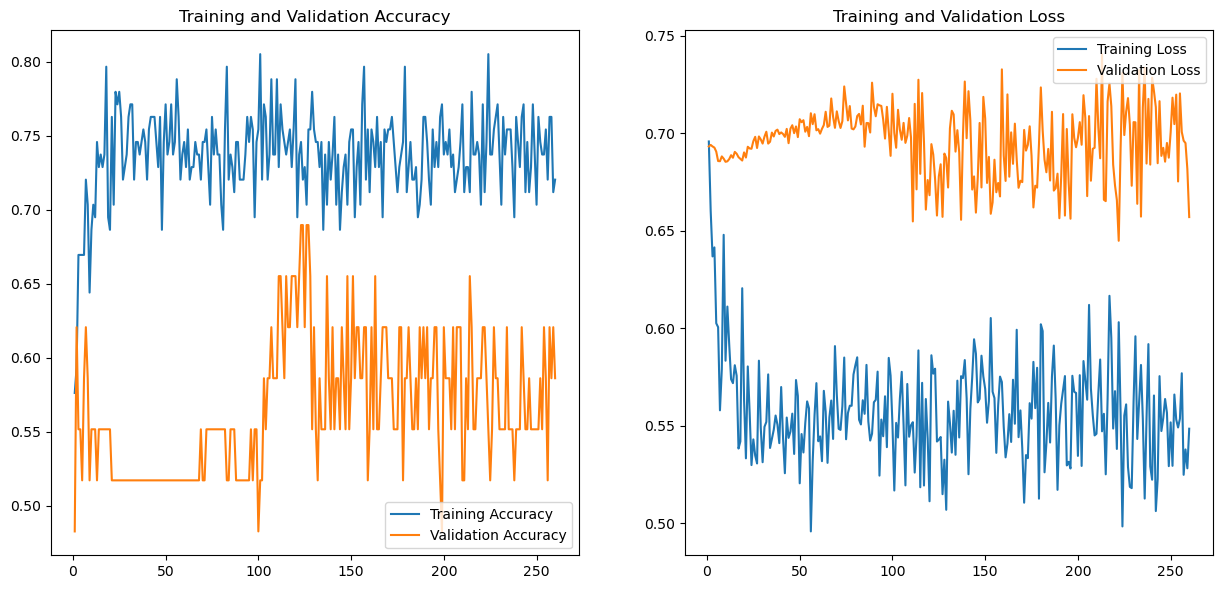

Validation accuracy: 0.552
Epoch 1/260
4/4 [==============================] - 3s 529ms/step - loss: 0.9312 - accuracy: 0.3983 - val_loss: 0.6933 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 220ms/step - loss: 0.7305 - accuracy: 0.5847 - val_loss: 0.6928 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 286ms/step - loss: 0.6548 - accuracy: 0.6525 - val_loss: 0.6925 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 280ms/step - loss: 0.6786 - accuracy: 0.6610 - val_loss: 0.6922 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 247ms/step - loss: 0.6616 - accuracy: 0.6610 - val_loss: 0.6930 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 286ms/step - loss: 0.6479 - accuracy: 0.6610 - val_loss: 0.6927 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 1s 223ms/step - loss: 0.6354 - accuracy: 0.6610 - val_loss: 0.6945 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 244ms/step - loss: 0.6143 - accuracy: 0.6610 - val_loss: 0.6942 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 277ms/step - loss: 0.6406 - accuracy: 0.6610 - val_loss: 0.6943 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 56/260
4/4 [==============================] - 1s 228ms/step - loss: 0.6250 - accuracy: 0.6610 - val_loss: 0.6949 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 57/260
4/4 [==============================] - 1s 290ms/step - loss: 0.6240 - accuracy: 0.6610 - val_loss: 0.6945 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 1s 297ms/step - loss: 0.6388 - accuracy: 0.6525 - val_loss: 0.6948 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 271ms/step - loss: 0.6201 - accuracy: 0.6610 - val_loss: 0.6994 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 319ms/step - loss: 0.6426 - accuracy: 0.6610 - val_loss: 0.6971 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 106/260
4/4 [==============================] - 1s 294ms/step - loss: 0.6396 - accuracy: 0.6610 - val_loss: 0.6959 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 107/260
4/4 [==============================] - 1s 290ms/step - loss: 0.6213 - accuracy: 0.6610 - val_loss: 0.6969 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 1s 250ms/step - loss: 0.6278 - accuracy: 0.6610 - val_loss: 0.7000 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 248ms/step - loss: 0.6322 - accuracy: 0.6610 - val_loss: 0.6981 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 306ms/step - loss: 0.6408 - accuracy: 0.6610 - val_loss: 0.7061 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 290ms/step - loss: 0.6370 - accuracy: 0.6610 - val_loss: 0.7033 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 297ms/step - loss: 0.6174 - accuracy: 0.6610 - val_loss: 0.6974 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 158/260
4/4 [==============================] - 1s 307ms/step - loss: 0.6298 - accuracy: 0.6610 - val_loss: 0.6988 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 258ms/step - loss: 0.6363 - accuracy: 0.6610 - val_loss: 0.7148 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 310ms/step - loss: 0.6372 - accuracy: 0.6610 - val_loss: 0.7065 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 260ms/step - loss: 0.6572 - accuracy: 0.6610 - val_loss: 0.6976 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 247ms/step - loss: 0.6288 - accuracy: 0.6610 - val_loss: 0.6976 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 247ms/step - loss: 0.6318 - accuracy: 0.6610 - val_loss: 0.7051 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 209/260
4/4 [==============================] - 1s 292ms/step - loss: 0.6366 - accuracy: 0.6610 - val_loss: 0.7032 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 1s 277ms/step - loss: 0.6230 - accuracy: 0.6610 - val_loss: 0.6992 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 1s 284ms/step - loss: 0.6462 - accuracy: 0.6610 - val_loss: 0.6964 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 272ms/step - loss: 0.6297 - accuracy: 0.6610 - val_loss: 0.7093 - val_accuracy: 0.5172 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 277ms/step - loss: 0.6417 - accuracy: 0.6610 - val_loss: 0.6961 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 259/260
4/4 [==============================] - 1s 293ms/step - loss: 0.6167 - accuracy: 0.6610 - val_loss: 0.6991 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 260/260
4/4 [==============================] - 1s 274ms/step - loss: 0.6370 - accuracy: 0.6610 - val_loss: 0.7083 - val_accuracy: 0.5172 - lr: 1.0000e-28


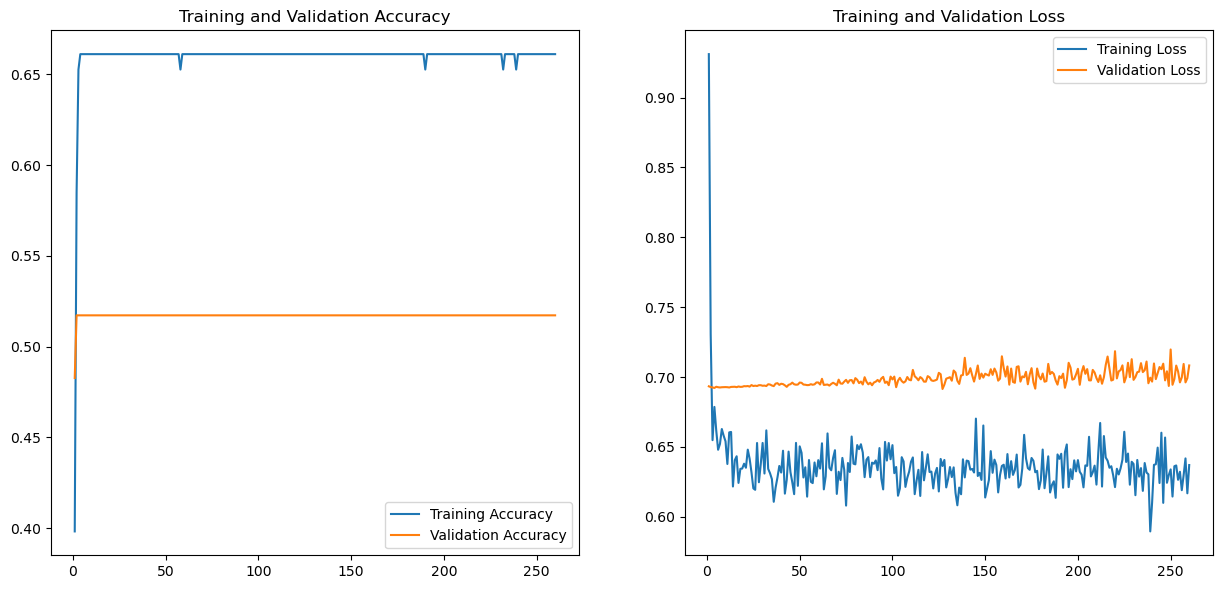

Validation accuracy: 0.517
Epoch 1/260
4/4 [==============================] - 2s 377ms/step - loss: 0.9836 - accuracy: 0.5424 - val_loss: 0.6968 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 263ms/step - loss: 0.7270 - accuracy: 0.6271 - val_loss: 0.6799 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 237ms/step - loss: 0.6339 - accuracy: 0.6610 - val_loss: 0.6746 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 249ms/step - loss: 0.7310 - accuracy: 0.6695 - val_loss: 0.6895 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 263ms/step - loss: 0.6887 - accuracy: 0.7203 - val_loss: 0.6884 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 232ms/step - loss: 0.5969 - accuracy: 0.6695 - val_loss: 0.6819 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 7/260
4/4 [==============================] 

Epoch 53/260
4/4 [==============================] - 2s 350ms/step - loss: 0.5540 - accuracy: 0.7119 - val_loss: 0.7536 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 2s 367ms/step - loss: 0.5501 - accuracy: 0.7203 - val_loss: 0.7497 - val_accuracy: 0.4828 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 2s 409ms/step - loss: 0.5184 - accuracy: 0.7373 - val_loss: 0.7419 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 2s 384ms/step - loss: 0.5159 - accuracy: 0.7797 - val_loss: 0.7279 - val_accuracy: 0.5517 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 1s 341ms/step - loss: 0.5690 - accuracy: 0.7288 - val_loss: 0.7346 - val_accuracy: 0.5517 - lr: 1.0000e-07
Epoch 58/260
4/4 [==============================] - 2s 386ms/step - loss: 0.5315 - accuracy: 0.7119 - val_loss: 0.7240 - val_accuracy: 0.5862 - lr: 1.0000e-07
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 320ms/step - loss: 0.5513 - accuracy: 0.6949 - val_loss: 0.7214 - val_accuracy: 0.6897 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 262ms/step - loss: 0.5315 - accuracy: 0.7119 - val_loss: 0.7283 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 350ms/step - loss: 0.5579 - accuracy: 0.7458 - val_loss: 0.7135 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 2s 376ms/step - loss: 0.5812 - accuracy: 0.6949 - val_loss: 0.7401 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 108/260
4/4 [==============================] - 1s 310ms/step - loss: 0.5438 - accuracy: 0.7288 - val_loss: 0.7341 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 109/260
4/4 [==============================] - 1s 329ms/step - loss: 0.5191 - accuracy: 0.7627 - val_loss: 0.7610 - val_accuracy: 0.5517 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 321ms/step - loss: 0.5337 - accuracy: 0.7458 - val_loss: 0.7075 - val_accuracy: 0.4828 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 330ms/step - loss: 0.5252 - accuracy: 0.7119 - val_loss: 0.7149 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 325ms/step - loss: 0.5681 - accuracy: 0.7119 - val_loss: 0.7294 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 158/260
4/4 [==============================] - 1s 322ms/step - loss: 0.5726 - accuracy: 0.7373 - val_loss: 0.6990 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 159/260
4/4 [==============================] - 1s 291ms/step - loss: 0.5722 - accuracy: 0.7034 - val_loss: 0.7168 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 160/260
4/4 [==============================] - 1s 293ms/step - loss: 0.5156 - accuracy: 0.7542 - val_loss: 0.6879 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 334ms/step - loss: 0.5333 - accuracy: 0.7203 - val_loss: 0.7171 - val_accuracy: 0.5517 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 319ms/step - loss: 0.5157 - accuracy: 0.7288 - val_loss: 0.7194 - val_accuracy: 0.5517 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 306ms/step - loss: 0.5630 - accuracy: 0.7373 - val_loss: 0.7071 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 325ms/step - loss: 0.5058 - accuracy: 0.7712 - val_loss: 0.7328 - val_accuracy: 0.5862 - lr: 1.0000e-22
Epoch 210/260
4/4 [==============================] - 1s 336ms/step - loss: 0.5719 - accuracy: 0.7119 - val_loss: 0.7219 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 211/260
4/4 [==============================] - 1s 336ms/step - loss: 0.5095 - accuracy: 0.7458 - val_loss: 0.7471 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 266ms/step - loss: 0.5636 - accuracy: 0.7119 - val_loss: 0.7009 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 330ms/step - loss: 0.5593 - accuracy: 0.7119 - val_loss: 0.7062 - val_accuracy: 0.6207 - lr: 1.0000e-27
Epoch 259/260
4/4 [==============================] - 1s 320ms/step - loss: 0.5289 - accuracy: 0.7458 - val_loss: 0.7071 - val_accuracy: 0.5862 - lr: 1.0000e-27
Epoch 260/260
4/4 [==============================] - 1s 340ms/step - loss: 0.5684 - accuracy: 0.7288 - val_loss: 0.7125 - val_accuracy: 0.5862 - lr: 1.0000e-27


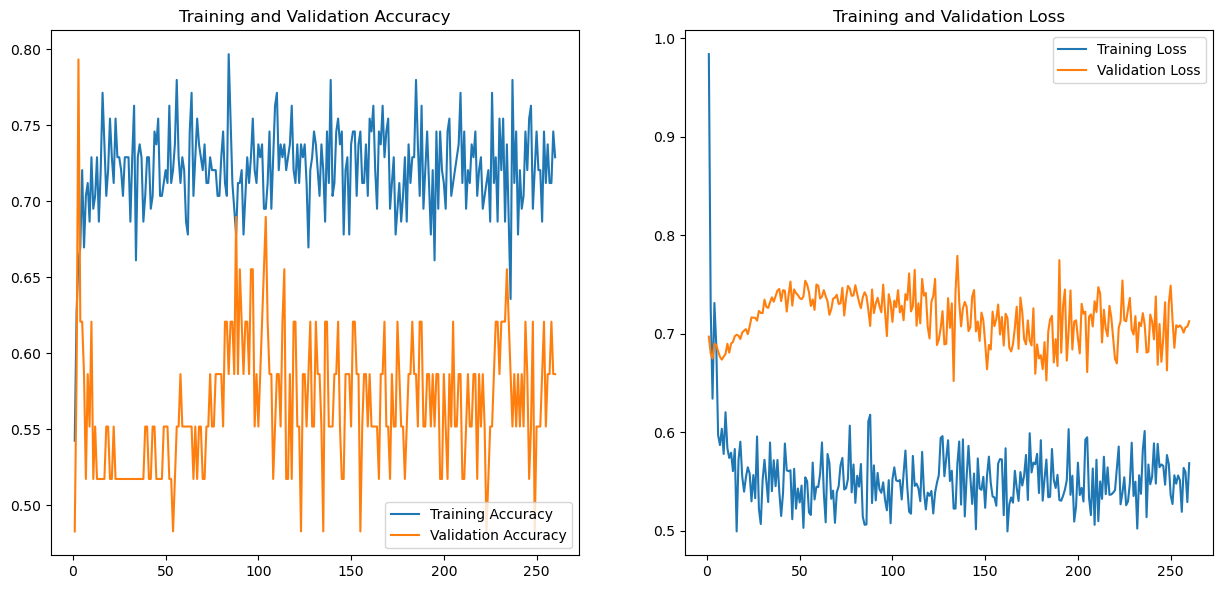

Validation accuracy: 0.552


In [15]:
batch_size = 42
acc_o_aug = []
for i in range(10):
    model_o_aug = cnn_o_aug()
    learning_rate = 0.001
    model_o_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])
    train_o_aug = model_o_aug.fit(aug_train_o, 
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = aug_val_o,
                     callbacks = [reduce_on_plateau])
    acc = train_o_aug.history['accuracy']
    val_acc = train_o_aug.history['val_accuracy']
    loss = train_o_aug.history['loss']
    val_loss = train_o_aug.history['val_loss']

    epochs_range = range(1, len(acc)+1)

    #Train and validation accuracy 
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    #Train and validation loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    _, val_acc = model_o_aug.evaluate(aug_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o_aug.append(val_acc)

In [16]:
media_o_aug = np.mean(acc_o_aug)
std_o_aug = np.std(acc_o_aug)
print(media_o_aug)
print(std_o_aug)

0.5551724016666413
0.03600105454521072


In [17]:
acc_o = []
acc_o_aug = []
for i in range(10):
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o.append(val_acc)

    _, val_acc = model_o_aug.evaluate(aug_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o_aug.append(val_acc)

Validation accuracy: 0.700
Validation accuracy: 0.621
Validation accuracy: 0.700
Validation accuracy: 0.586
Validation accuracy: 0.700
Validation accuracy: 0.552
Validation accuracy: 0.700
Validation accuracy: 0.552
Validation accuracy: 0.700
Validation accuracy: 0.586
Validation accuracy: 0.700
Validation accuracy: 0.517
Validation accuracy: 0.700
Validation accuracy: 0.552
Validation accuracy: 0.700
Validation accuracy: 0.552
Validation accuracy: 0.700
Validation accuracy: 0.586
Validation accuracy: 0.700
Validation accuracy: 0.621
